<img src="img/rossmann_drugstore.jpg" alt="A Rossmann store" width="1000" style="display: block; margin-left: auto; margin-right: auto"/>

# 0.0 - INTRO

## 0.1 - IMPORTS

In [1]:
import pandas as pd
import inflection as sc
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import joblib
import os
from random import sample
import memory_profiler

# scaling and encoding
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# ml models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression
from xgboost import XGBRegressor

# bayesian optmization
from bayes_opt import BayesianOptimization
from bayes_opt.util import Colours

# feature selecion
from boruta import BorutaPy

# Funções auxiliares
import helpers

In [2]:
%matplotlib inline
helpers.jupyter_settings()

## 0.2 - LOADING DATA

In [10]:
# https://www.kaggle.com/c/rossmann-store-sales/data
df_sales_raw = pd.read_csv("data/train.csv")
df_store_raw = pd.read_csv("data/store.csv")

In [11]:
df_sales_raw.query("Store == 1047").sample(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
979231,1047,1,2013-02-04,7173,646,1,1,0,0
552186,1047,6,2014-02-22,3172,383,1,0,0,0
704941,1047,2,2013-10-08,6191,589,1,1,0,0


In [12]:
df_store_raw.query("Store == 1047")

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1046,1047,a,a,3750.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"


### merge

In [13]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how="left", on="Store")
df_raw.query("Store == 1047").sample(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
839856,1047,7,2013-06-09,0,0,0,0,0,0,a,a,3750.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
131501,1047,7,2015-04-05,0,0,0,0,0,0,a,a,3750.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
716091,1047,6,2013-09-28,3308,354,1,0,0,0,a,a,3750.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"


# 1.0 - DESCRIÇÃO DOS DADOS

In [14]:
df1 = df_raw.copy()

## 1.1 - Rename Columns

In [15]:
cols_old = list(df1.columns)

snakecase = lambda x: sc.underscore(x)
df1.columns = map(snakecase, cols_old)

In [16]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 - Data Dimensions

In [17]:
print("Number of Rows: {}".format(df1.shape[0]))
print("Number of Cols: {}".format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 - Data Types

In [18]:
df1["date"] = pd.to_datetime(df1["date"])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 - Check NA

In [19]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

> Há (em suma) 3 formas de tratar missing values (nas colunas):
> - Excluir a coluna;
> - Imputação por algoritmos de ML; ou
> - Pensar no negócio e Imputar com o que achar que é mais lógico. (Esse foi o método escolhido para esse treinamento para exercitar o lado de negócios)

## 1.5 - Fillout NA

> Entender (se possível) o porquê de cada missing value e tratar da melhor forma possível.

`competition_distance`: Iremos assumir que os valores NA receberão uma distancia muito maior ao que é encontrado no dataset.Como o max dessa coluna é 75860, podemos atribuir 200000 aos valores NA, indicando que os competidores estão extremamente longes.

In [20]:
df1['competition_distance'].max()

75860.0

In [21]:
input_above_max = lambda x: 200000.0 if math.isnan(x) else x

df1['competition_distance'] = df1['competition_distance'].apply(
    input_above_max)

---
`competition_open_since[_month/_year]`: Saber a quanto tempo um competidor mais proximo está aberto será importante para a fase de feature engineering, pois teoricamente as vendas tendem a cair quando um novo competidor abre uma loja proxima e tendem a se normalizar depois de um tempo.
A _assumption_ que optamos para tratar os dados faltantes é colocar a data da venda como sendo a data dessa coluna tbm, pois assim o tempo desde que a loja competidora foi aberta será 0; Talvez seja necessário alterar essa afirmação nas proximas iterações do CRISP.


In [22]:
input_date_month_if_na = lambda x: x['date'].month if math.isnan(x[
    'competition_open_since_month']) else x['competition_open_since_month']
df1['competition_open_since_month'] = df1.apply(input_date_month_if_na, axis=1)

input_date_year_if_na = lambda x: x['date'].year if math.isnan(x[
    'competition_open_since_year']) else x['competition_open_since_year']
df1['competition_open_since_year'] = df1.apply(input_date_year_if_na, axis=1)

`promo2_since[_week/_year]`: Quando a loja não está participando da promo 2, que é uma continuaçao de alguma promoção, então essas duas colunas serão NA.
    Logo podemos fazer como acima e utilizar a coluna `date` para que no feature engineering essa distancia seja 0.

In [23]:
input_date_week_if_na = lambda x: x['date'].week if math.isnan(x[
    'promo2_since_week']) else x['promo2_since_week']
df1['promo2_since_week'] = df1.apply(input_date_week_if_na, axis=1)

input_date_year_if_na = lambda x: x['date'].year if math.isnan(x[
    'promo2_since_year']) else x['promo2_since_year']
df1['promo2_since_year'] = df1.apply(input_date_year_if_na, axis=1)

`promo_interval`: A estratégia que iremos utilizar aqui é imputar com 0 onde for NA. Além disso outras duas colunas serão criadas: `month_map` que recebera o mês de date como mês em 3 letras em inglês; `is_promo` (referente à promo2) que será 0 se promo_interval for 0 ou se mês não estiver contido na lista de meses em promo_interval e 1 caso contrário (se estiver em periodo de promoção extendida)

In [24]:
month_map = {
    1: 'Jan',
    2: 'Fev',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

is_promo_func = (lambda x: 0 if x['promo_interval'] == 0 else 1
                 if x['month_map'] in x['promo_interval'].split(',') else 0)
df1['is_promo'] = df1.apply(is_promo_func, axis=1)

In [25]:
df1.sample(3).T

,714012,251130,428896
store,83,869,407
day_of_week,7,2,4
date,2013-09-29 00:00:00,2014-12-16 00:00:00,2014-06-12 00:00:00
sales,0,11947,3608
customers,0,1330,288
open,0,1,1
promo,0,1,0
state_holiday,0,0,0
school_holiday,0,0,1
store_type,a,c,a


In [26]:
# verificação final: tudo ok (para o ciclo 1)
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 - Change types

> Fazendo algumas correções extras nos tipos dos dados 

In [27]:
df1['state_holiday'] = df1['state_holiday'].astype(str)

# esses valores estavam como float, porém devem ser int
df1['competition_open_since_month'] = df1[
    'competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(
    int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 - Descriptive Statistical

Objetivos:
> Ganhar conhecimento de negócio

> Detectar alguns erros

__É necessário <u>dividir</u> o conjunto de dados em variáveis <u>categóricas</u> e <u>numéricas</u> para fazer as análises__

In [28]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(
    exclude=['int64', 'float64', 'datetime64[ns]'])

In [29]:
num_attributes.dtypes

store                             int64
day_of_week                       int64
sales                             int64
customers                         int64
open                              int64
promo                             int64
school_holiday                    int64
competition_distance            float64
competition_open_since_month      int64
competition_open_since_year       int64
promo2                            int64
promo2_since_week                 int64
promo2_since_year                 int64
is_promo                          int64
dtype: object

### 1.7.1 - Numerical Attributes

In [30]:
# Gerando uma lista com todas as estatisticas de interesse
list_funcs = []

# Central tendency => mean, median
list_funcs += [np.mean, np.median]

# Dispersion => std, min, max, range, skew, kurtosis
list_funcs += [
    np.std, min, max, lambda x: x.max() - x.min(), lambda x: x.skew(),
    lambda x: x.kurtosis()
]

# iterando por cada estatistica e depois concatenando todas em um dataset
to_concat = [num_attributes.apply(func).to_frame().T for func in list_funcs]

m = pd.concat(to_concat).T.reset_index()
m.columns = [
    'attribute', 'mean', 'median', 'std', 'min', 'max', 'range', 'skew',
    'kurtosis'
]

In [31]:
m

,attribute,mean,median,std,min,max,range,skew,kurtosis
0,store,558.429727,558.0,321.908493,1.0,1115.0,1114.0,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.997390,1.0,7.0,6.0,0.001593,-1.246873
2,sales,5773.818972,5744.0,3849.924283,0.0,41551.0,41551.0,0.641460,1.778375
3,customers,633.145946,609.0,464.411506,0.0,7388.0,7388.0,1.598650,7.091773
4,open,0.830107,1.0,0.375539,0.0,1.0,1.0,-1.758045,1.090723
5,promo,0.381515,0.0,0.485758,0.0,1.0,1.0,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.0,1.677842,0.815154
7,competition_distance,5935.442677,2330.0,12547.646829,20.0,200000.0,199980.0,10.242344,147.789712
8,competition_open_since_month,6.786849,7.0,3.311085,1.0,12.0,11.0,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,5.515591,1900.0,2015.0,115.0,-7.235657,124.071304


> Skew: concentração dos dados. se + está para esquerda e se - está para a direita

> kurtosis: Muito alto indica que possui um pico muito alto, caso contrário está mais esparso

<AxesSubplot:>

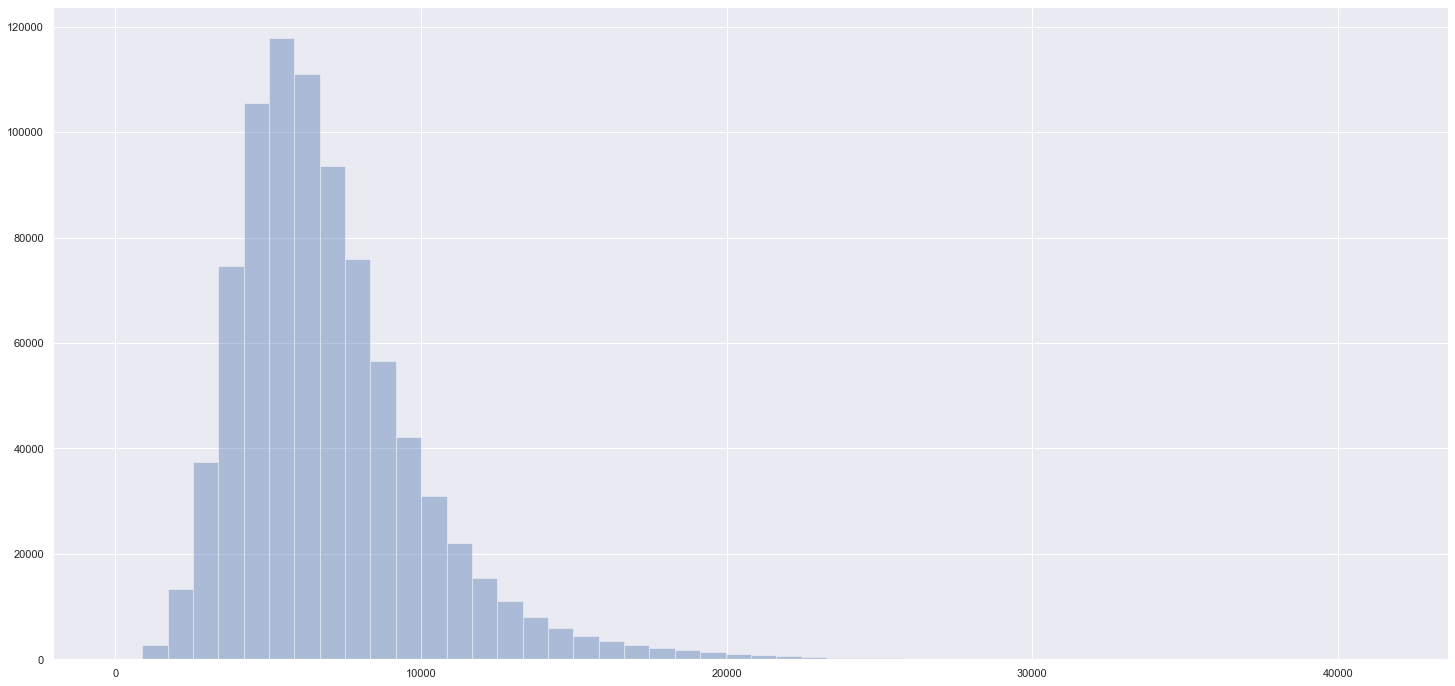

In [46]:
# Distribuição de vendas retirando os dias sem vendas (lojas fechadas)
sns.distplot(num_attributes[['sales']].query("sales != 0"), kde=False)

### 1.7.2 - Categorical Attributes

In [39]:
# quantidade de categorias em cada variavel
cat_attributes.apply(lambda x: x.unique().shape)

,state_holiday,store_type,assortment,promo_interval,month_map
0,4,4,3,4,12


In [40]:
# Existem muitos dias em que as lojas estavam fechadas, logo não tiveram vendas.
# Então é necessário tirar esses valores para o gráfico ficar mais visivel
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
aux1.sample(2)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
242267,335,4,2014-12-25,4146,726,1,0,c,1,b,a,90.0,12,2014,1,31,2013,"Jan,Apr,Jul,Oct",Dec,0
851033,1074,4,2013-05-30,6758,679,1,1,a,0,c,c,3330.0,10,2001,1,14,2011,"Jan,Apr,Jul,Oct",May,0


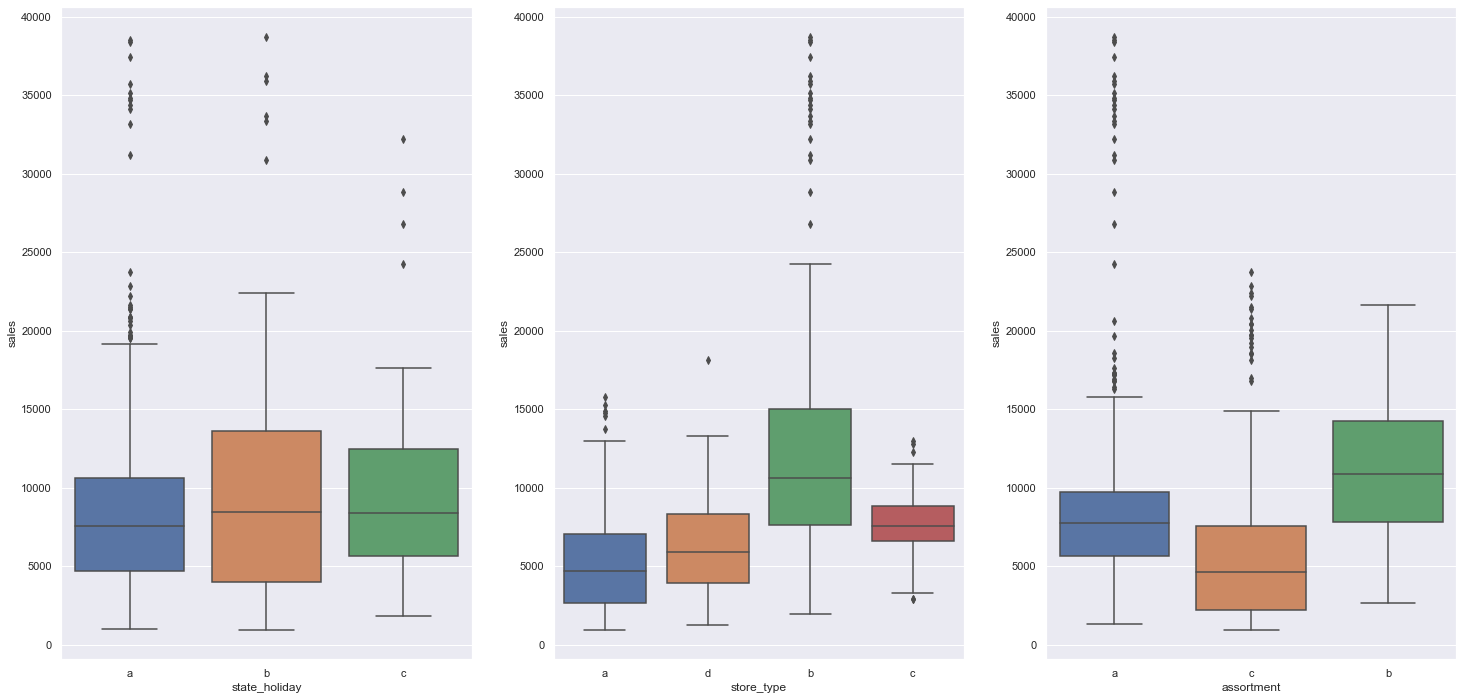

In [41]:
# note que y é var continua e x é var categorica

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)

sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)
plt.show()

__Observações__

- Feriados estaduais x sales:
    > - As medianas dos feriados `b` e `c` são semelhantes e maiores que `a`;
    > - O feriado `b` possui um range min-max maior que os demais;
    > - A distribuição do feriado `c` possui uma distorção para esquerda;
    > - O feriado `a` possui uma maior concentração das vendas que os demais;

- Tipo de loja x sales:
    > - O tipo `c` possui uma concentração maior que os demais;
    > - O tipo `b` possui o maior range min-max, uma distorção para a esquerda, ainda a maior numero de outliers e a maior mediana;

- assortment x sales:
    > - a categoria `a` possui mais outliers e maior concentração (maior kurtosis)
    > - O assortment `b` tem a maior mediana


# 2.0 - FEATURE ENGINEERING



In [53]:
df2 = df1.copy()

### 2.0.1 - Mapa Mental de Hipóteses

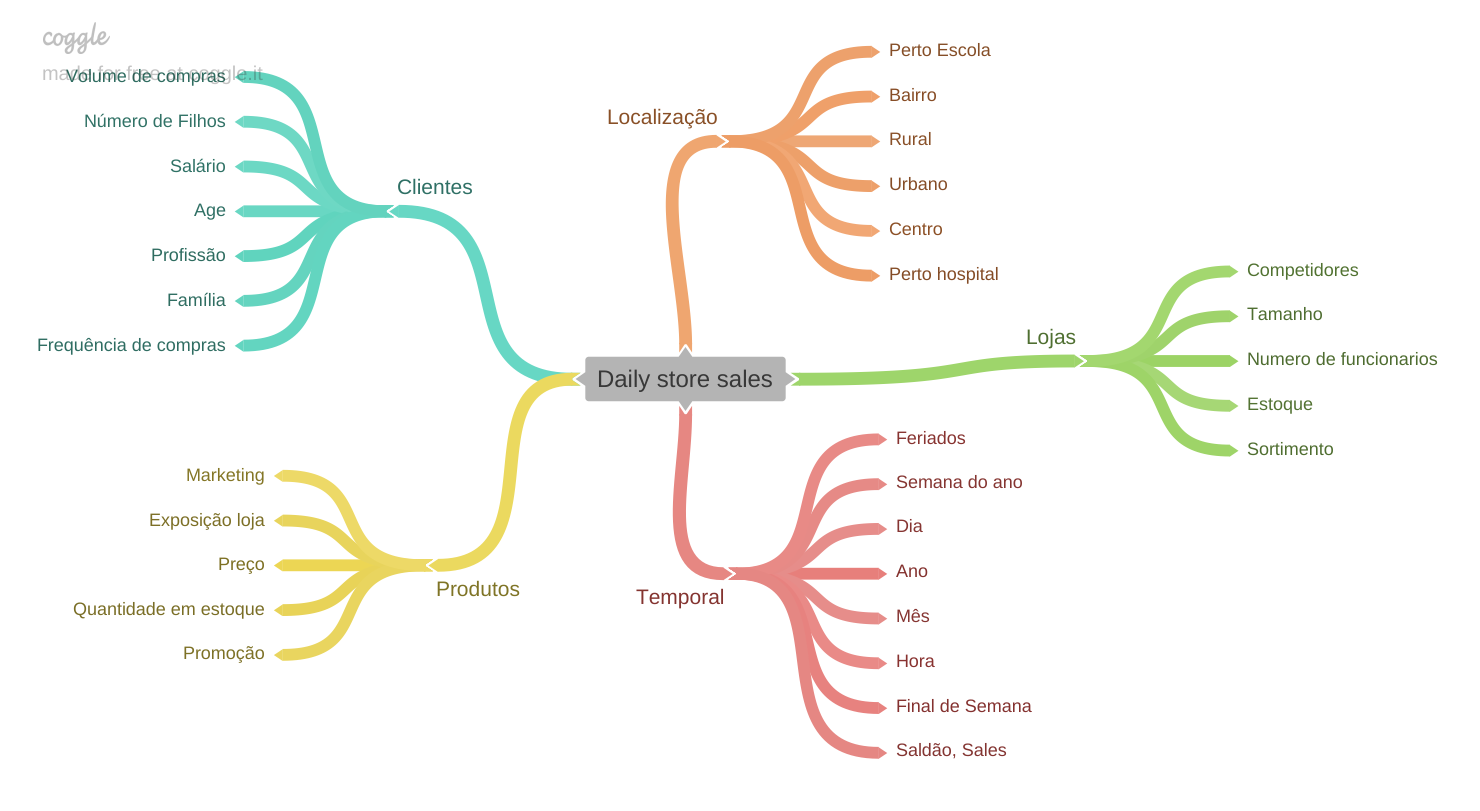

In [43]:
Image("img/Daily_store_sales.png", width=650)

## 2.1 - Criação das Hipóteses

**OBS:** 
> - Hipóteses são sempre achismos que devem ser aceitas ou rejeitadas através da EDA com os dados.
> - Sempre lembrar de que estamos avaliando correlação e não causalidade (ou seja: cada hipótese validada é apenas uma dentre varias que impactam na variavel resposta)

### 2.1.1 - Hipótese LOJA

1. Lojas com maior quadro de funcinarios deveriam vender mais. <sub>(nº de funcionários não disponivel nesse dataset)</sub>
2. Lojas com maior capacidade de estoque deveriam vender mais. <sub>(tam. estoque não dispponivel nesse dataset)</sub>
3. Lojas com maior porte deveriam vender mais. <sub>(tam da loja não disponivel)</sub>
4. Lojas com menor porte deveriam vender menos.
5. Lojas com competidores mais proximos deveriam vender menos. <sub>(infos de competidores estão no dataset)</sub>
6. Lojas com competidores à mais tempo deveriam vender mais. <sub>(infos de competidores estão no dataset)</sub>
7. Lojas com maior sortimento deveriam vender mais. <sub>(dados de sortimento estão contidos no dataset)</sub>

### 2.1.2 - Hipótese PRODUTO

1. Lojas que investem mais em marketing deveriam vender mais.
2. Lojas expoem mais os produtos nas vitrines deveriam vender mais.
3. Lojas que tem preços menores nos produtos deveriam vender mais.
5. Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais.
6. Lojas com mais dias de promoção deveriam vender mais.
7. Lojas com mais promoções consecutivas deveriam vender mais.
8. Lojas com promoções ativas por mais tempo deveriam vender mais. 


### 2.1.3 - Hipótese TEMPO

1. Lojas abertas durante o feriado de natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.


## 2.2 - Lista final de Hipóteses

**Para priorizar hipóteses:** Selecionar as que possuimos os dados necessarios nesse momento. Nas proximas iterações podemos buscar mais informações externas.

1. Lojas com maior sortimento deveriam vender mais.
2. Lojas com competidores mais proximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vender mais.

4. Lojas com mais dias de promoção deveriam vender mais.
5. Lojas com mais promoções consecutivas deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais. 

7. Lojas abertas durante o feriado de natal deveriam vender mais.
8. Lojas deveriam vender mais ao longo dos anos.
9. Lojas deveriam vender mais no segundo semestre do ano.
10. lojas deveriam vender mais depois do dia 10 de cada mês.
11. Lojas deveriam vender menos aos finais de semana.
12. Lojas deveriam vender menos durante os feriados escolares.

## 2.3 - Feature Engineering

In [54]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition since
def combine_year_month(x):
    return dt.datetime(year=x['competition_open_since_year'],
                       month=x['competition_open_since_month'],
                       day=1)


df2['competition_since'] = df2.apply(combine_year_month, axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) /
                                 30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(
    str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: dt.datetime.strptime(
    x + '-1', '%Y-%W-%w') - dt.timedelta(days=7))

## Diferença entre a data da compra e o inicio da promoçao em semanas
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) /
                          7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(
    lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
map_state_holiday = lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day'
df2['state_holiday'] = df2['state_holiday'].apply(map_state_holiday)

# 3.0 - FILTRAGEM DE VARIÁVEIS



In [55]:
df3 = df2.copy()

In [56]:
df3.shape, df3.columns

((1017209, 29),
 Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
        'state_holiday', 'school_holiday', 'store_type', 'assortment',
        'competition_distance', 'competition_open_since_month',
        'competition_open_since_year', 'promo2', 'promo2_since_week',
        'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'year',
        'month', 'day', 'week_of_year', 'year_week', 'competition_since',
        'competition_time_month', 'promo_since', 'promo_time_week'],
       dtype='object'))

**Obs**:
- Não é possível utilizar a feature `customers` diretamente, pois, não temos uma previsão de quantos clientes teremos daqui 6 semanas (precisaria de fazer um projeto separado para prever isso)
- Feature `open` não é importante, pois quando está fechado não há vendas, logo não há nenhum aprendizado para extrair aqui e podemos excluir todas as linhas onde `open` == 0 e `sales` != 0

## 3.1 - Filtragem das linhas

In [57]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 - Seleção das colunas



In [58]:
# coluna `open` sobrou apenas open==1, logo podemos exclui-la.
# Dropar colunas que foram usadas para derivar variaveis no processo de feature engineering
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [59]:
df3.shape  # retirou mais de 172k linhas e as 4 colunas

(844338, 25)

# 4.0 - ANÁLISE EXPLORATÓRIA DE DADOS (EDA)

In [60]:
df4 = df3.copy()

In [51]:
num_attributes_df4 = df4.select_dtypes(include=['int64', 'float64'])
cat_attributes_df4 = df4.select_dtypes(
    exclude=['int64', 'float64', 'datetime64[ns]'])

## 4.1 - Análise Univariada 

### 4.1.1 - Response variable

<AxesSubplot:xlabel='sales'>

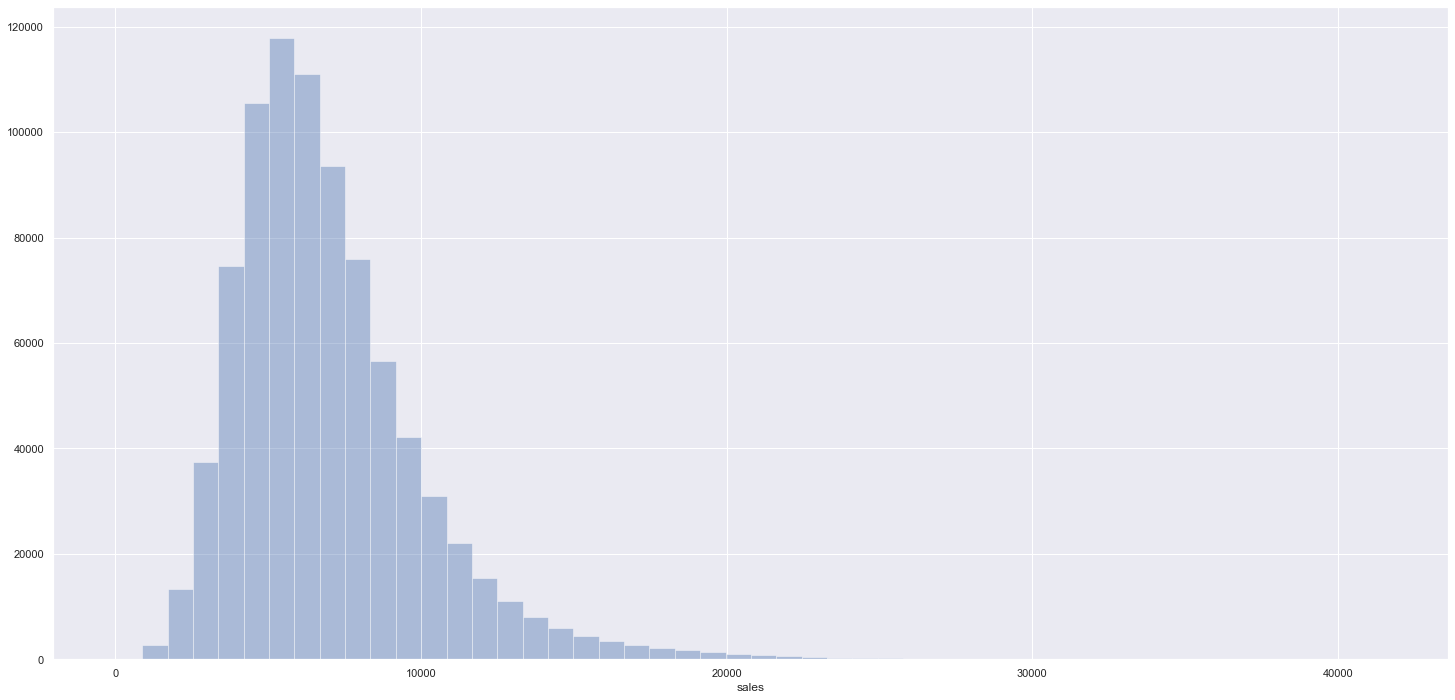

In [52]:
sns.distplot(df4['sales'], kde=False)

**Obs**:
- Tem formato de sino;
- Tem skew positiva
- Não está centrada
- Portanto está próxima de uma Normal, porém não é uma Normal
- Para aproximar mais da Normal, podemos fazer transformações, como aplicar log `(np.log1p(df4['sales']))` ou outras que depende do conhecimento do negócio

### 4.1.2 - Numerical variable

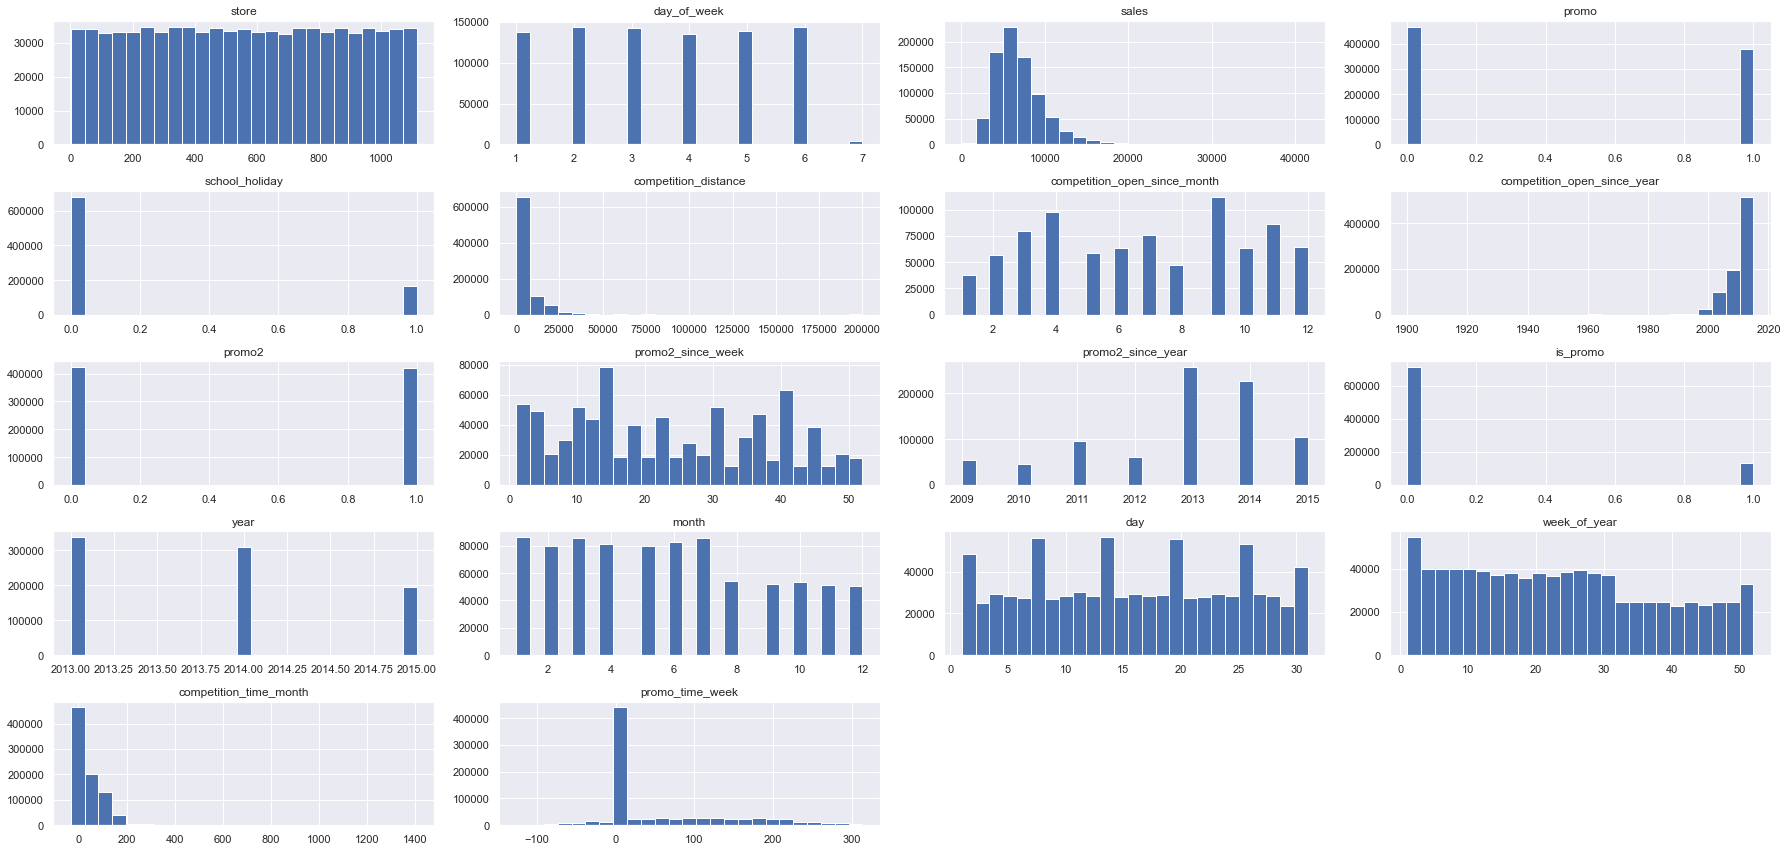

In [53]:
num_attributes_df4.hist(bins=25)
plt.tight_layout()

#### **Algumas análises**:

- `store`: A quantidade de registros (compras) por loja está quase uniforme, com poucas variações (pode ser melhor explorado).
- `day_of_week`: Aparentemente todos os dias da semana possuem quantidade de registros muito próximas, exceto domingo que possui bem menos (3593 registros).
- `sales`: possui um skew positivo. Média de 6955.96 e mediana de 6369.00.
- `promo`: ~56% dos registros __não__ estão em periodo de promoção, o restante com promoção.
- `school_holiday`: ~80% dos registro __não__ eram de dias em que as escolas estavam fechadas, o restante sim.
- `competition_distance`: A maioria dos competidores estão bem próximos.
- `competition_open_since_month`: Possui picos em Abril e Setembro.
- `competition_open_since_year`: Aparentemente a concorrência está aumentando com o passar do tempo (o que é bem lógico).
- `promo2`: ~ Metade das promoções foram extendidas (promo2)
- `promo2_since_week`: Há um pico nas semanas 12-14 (páscoa?) e 40-42 (alguma explicação?)
- `promo2_since_year`: 2015 possui menos registros,pois a competição foi lançado na metade de 2015, então não tem como tirar muitas conclusões. Apenas que as promos começaram a ser extendidas em maior quantidade depois de 2013.
- `is_promo`: Aproximadamente 85% dos registro não estão em periodo de promoção extendida
- `year`: Mesma observação sobre 2015 que fiz em promo2_since_year
- `month`: possui menos registros entre agosto e dezembro 
- `day`: Olhando para o histograma acima vemos picos em alguns grupos de dias, porém acho que está impreciso. Fazendo um count plot para cada dia, fica mais suave. Com maiores valores nos dias 11, 4, 27, 13 e 23 (nessa ordem) e menor no dia 1º de cada mês. 
- `week_of_year`: Maior número de registros nas semanas: 26 (max), 12, 9 e 11. E menores em: 52(min), 40 e 44
- `competition_time_month`: maior quantidade de registros em 0 e 1. Negativo significa que o competidor ainda não abriu (vai abrir x meses depois)
- `promo_time_week`: maiores em 0 e 52 semanas

### 4.1.3 - Categorical variable

In [54]:
cat_attributes_df4.sample()

,state_holiday,store_type,assortment,year_week
407554,regular_day,a,basic,2014-26


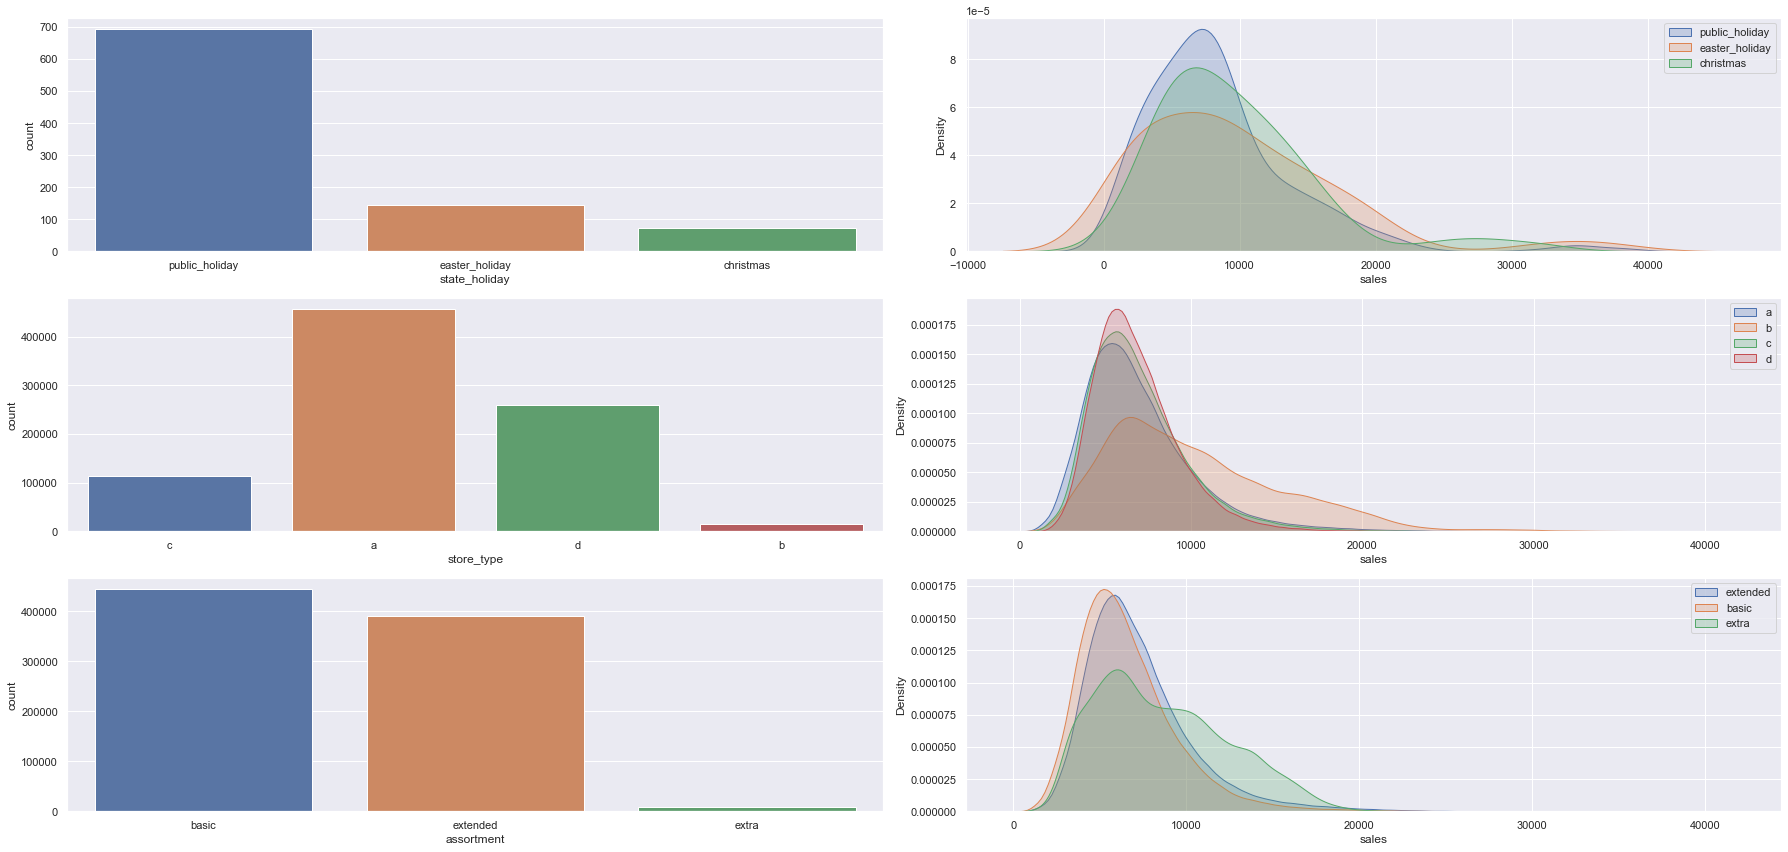

In [55]:
# state_holiday
aux4 = df4.query('state_holiday != "regular_day"')
plt.subplot(3, 2, 1)
sns.countplot(aux4['state_holiday'])

plt.subplot(3, 2, 2)
for holiday in ["public_holiday", "easter_holiday", "christmas"]:
    sns.kdeplot(x='sales',
                data=aux4.query(f'state_holiday == "{holiday}"'),
                label=holiday,
                shade=True)
plt.legend()
plt.tight_layout()

#------------------------------
# store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
for stype in ["a", "b", "c", "d"]:
    sns.kdeplot(x='sales',
                data=df4.query(f'store_type == "{stype}"'),
                label=stype,
                shade=True)

plt.legend()
plt.tight_layout()

#------------------------------
# assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
for assortment in ["extended", "basic", "extra"]
sns.kdeplot(x='sales',
            data=df4.query(f'assortment == "{assortment}"'),
            label=assortment,
            shade=True)
plt.legend()

plt.tight_layout()
plt.show()

## 4.2 - Análise Bivariada 

### Loja-H1. Lojas com maior sortimento deveriam vender mais
**FALSA**: Lojas com MAIOR SORTIMENTO vendem MENOS (considerando que `extra` significa mais sortimentos )

<AxesSubplot:xlabel='year_week'>

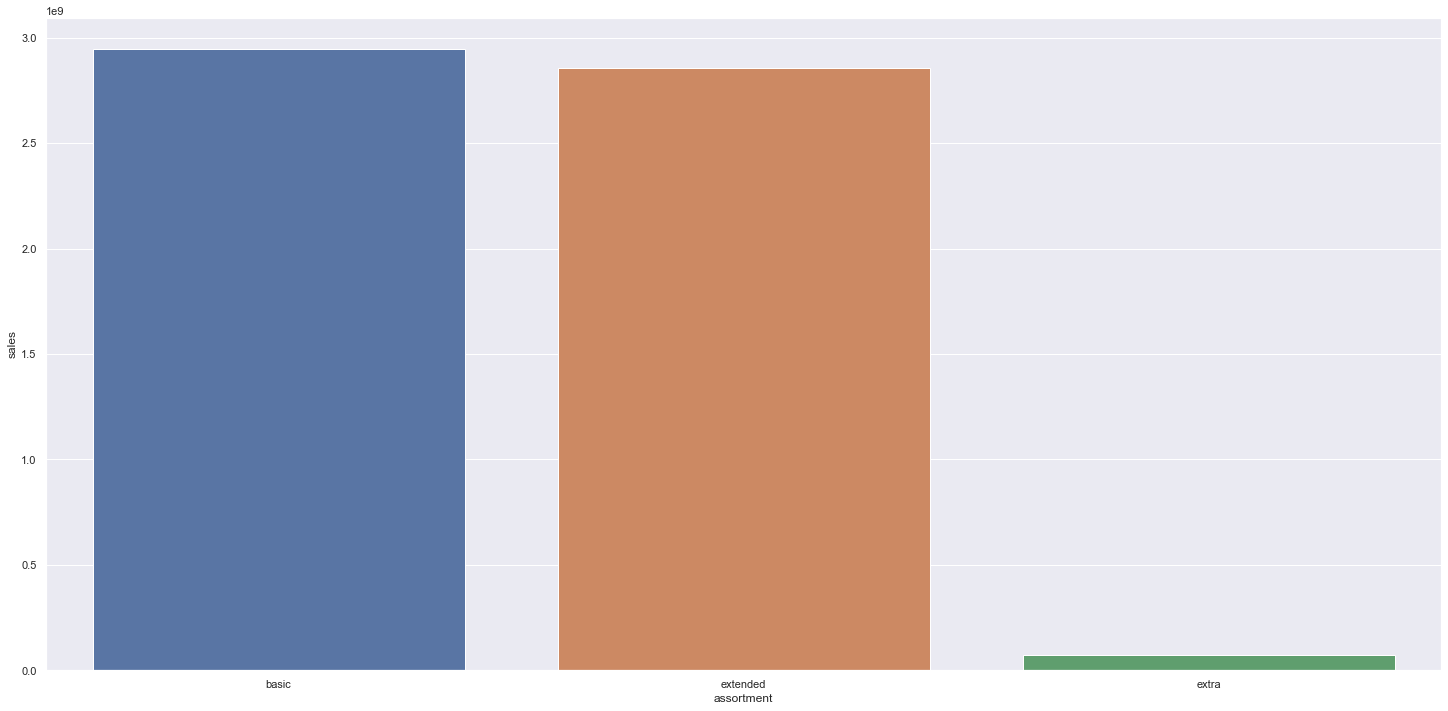

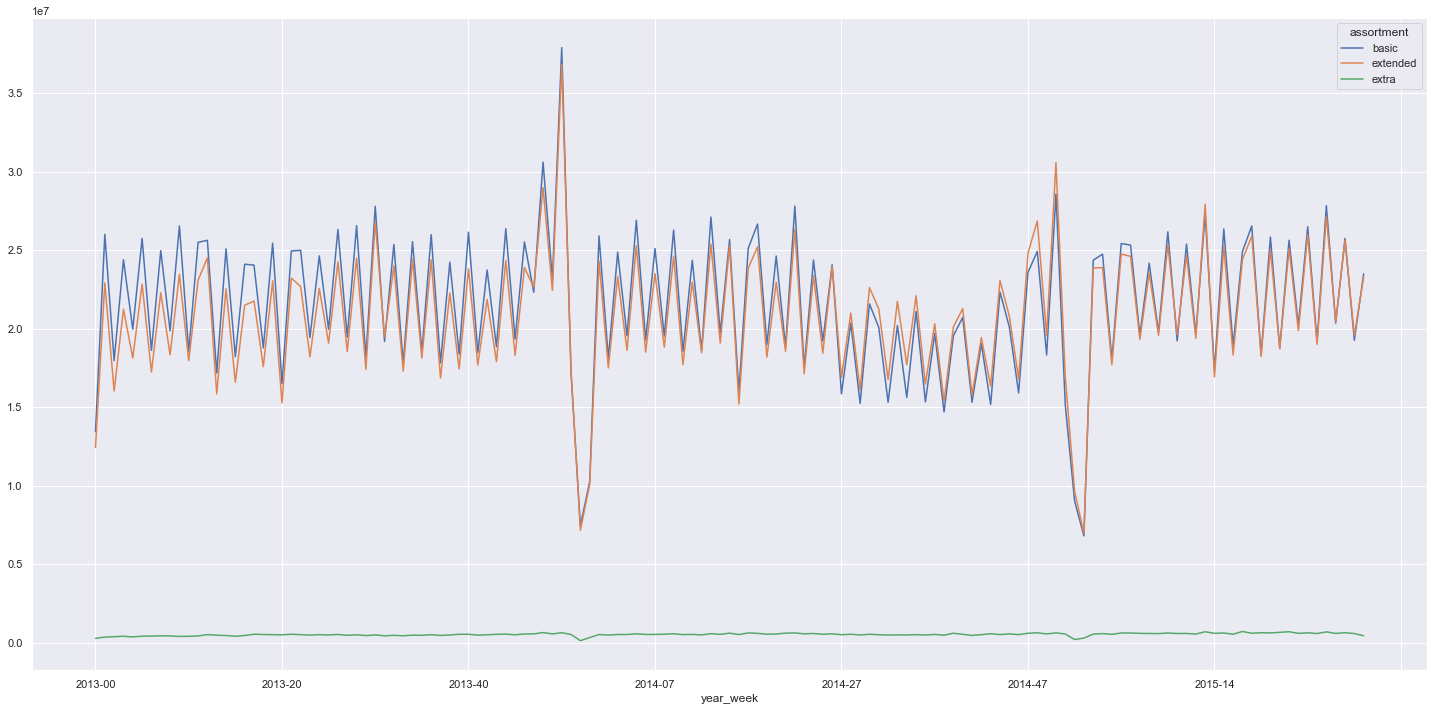

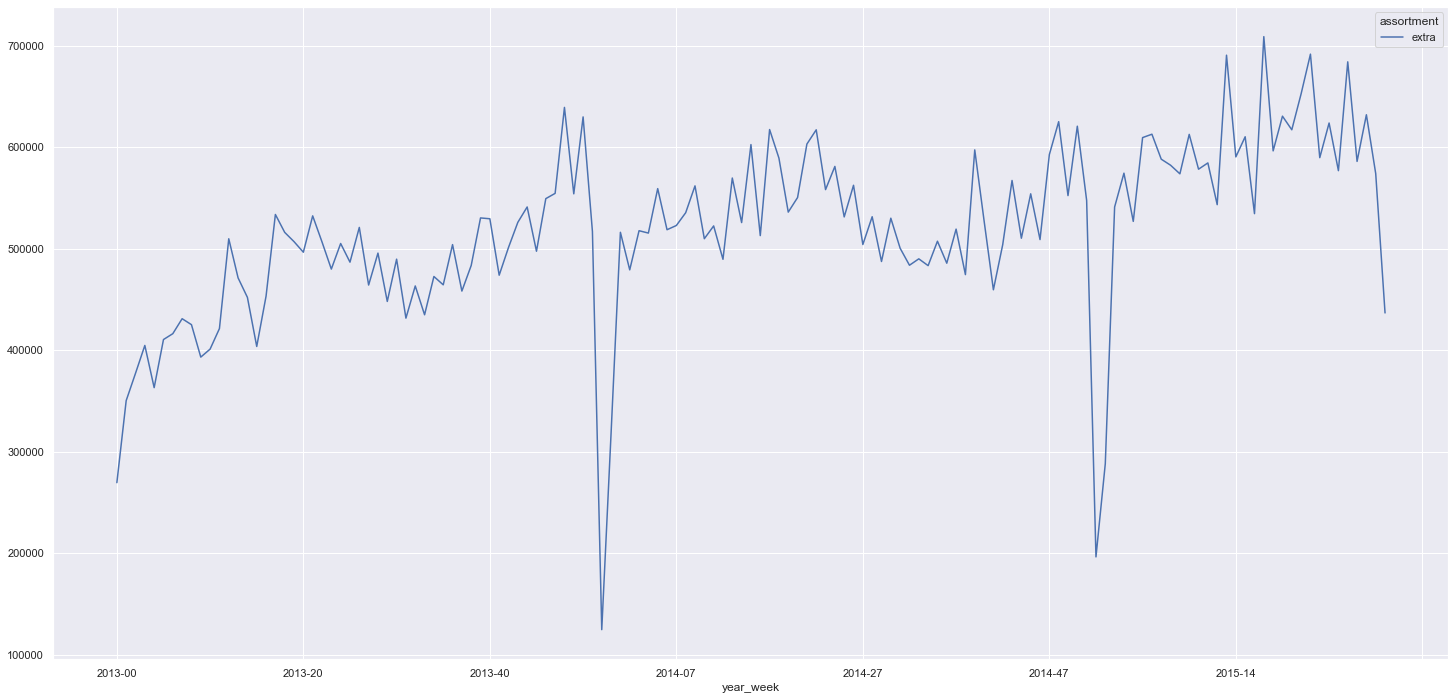

In [56]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)

aux2 = df4[['year_week', 'assortment',
            'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### Loja-H2. Lojas com competidores mais proximos deveriam vender menos
**FALSA:** Lojas com COMPETIDORES MAIS PROXIMOS vendem MENOS (por análise simples, e considerando que -.23 é uma correlação negativa suficiente)

<AxesSubplot:>

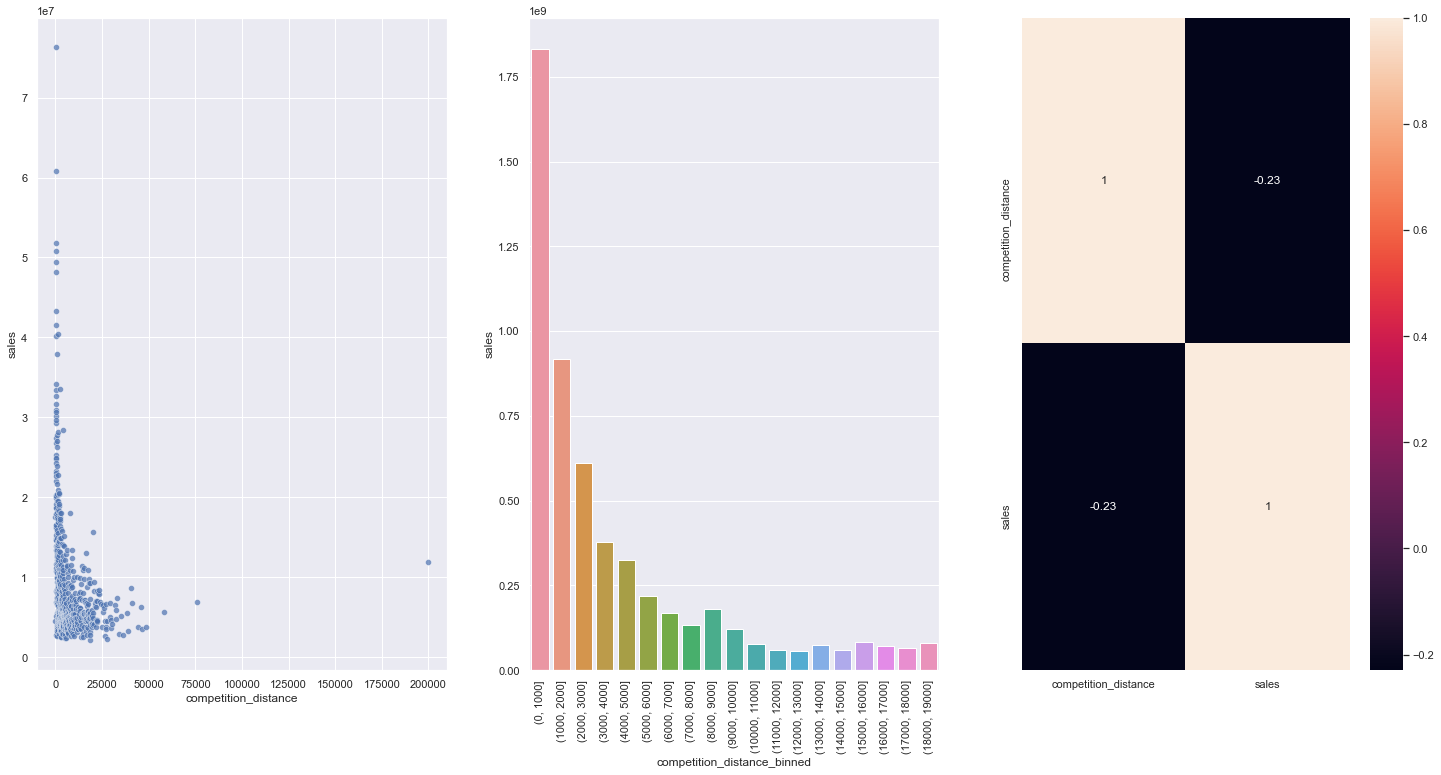

In [57]:
aux1 = df4[['competition_distance',
            'sales']].groupby(['competition_distance']).sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(
    x='competition_distance',
    y='sales',
    data=aux1,
    alpha=0.7,
)
# plt.xscale('log')

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'],
                                             bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales'
             ]].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
# ref para os tipos de correlações: https://datascience.stackexchange.com/questions/64260/pearson-vs-spearman-vs-kendall
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### Loja-H3. Lojas com competidores à mais tempo deveriam vender mais
**FALSA:** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS

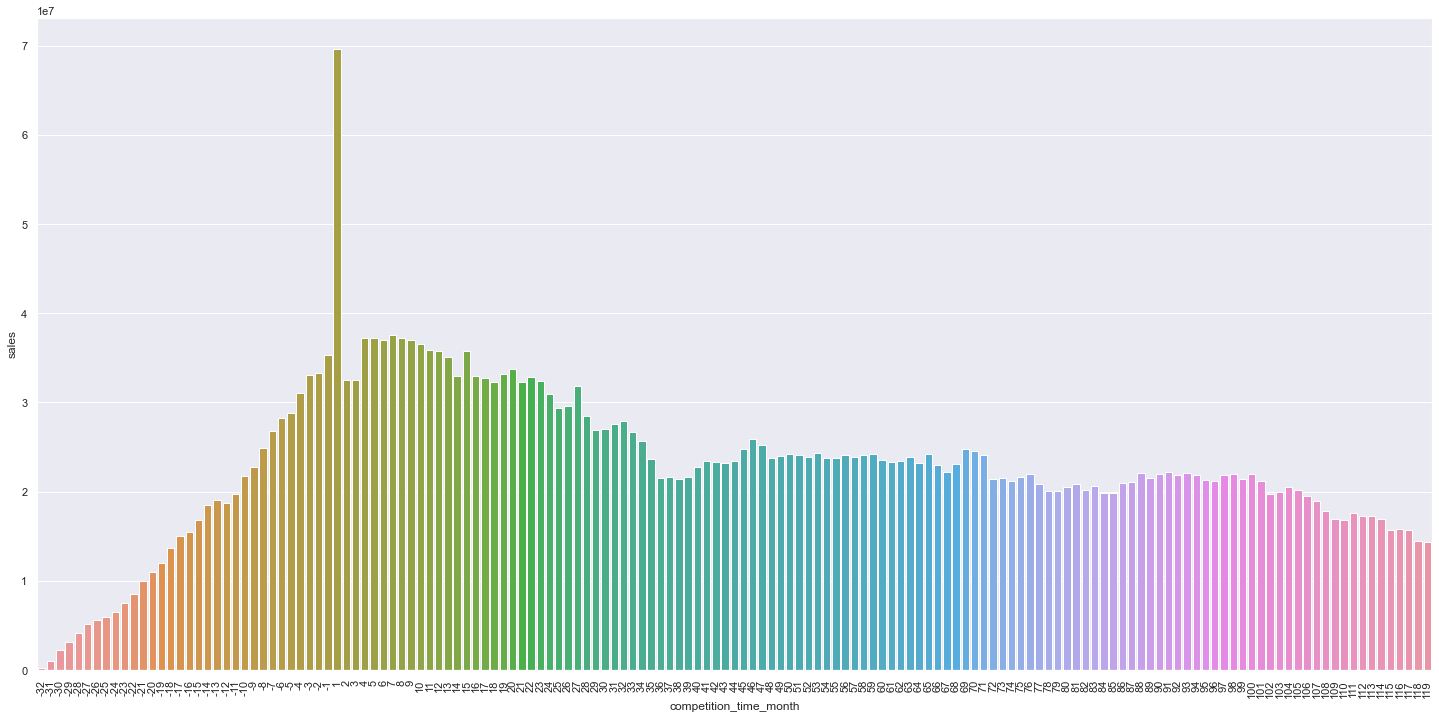

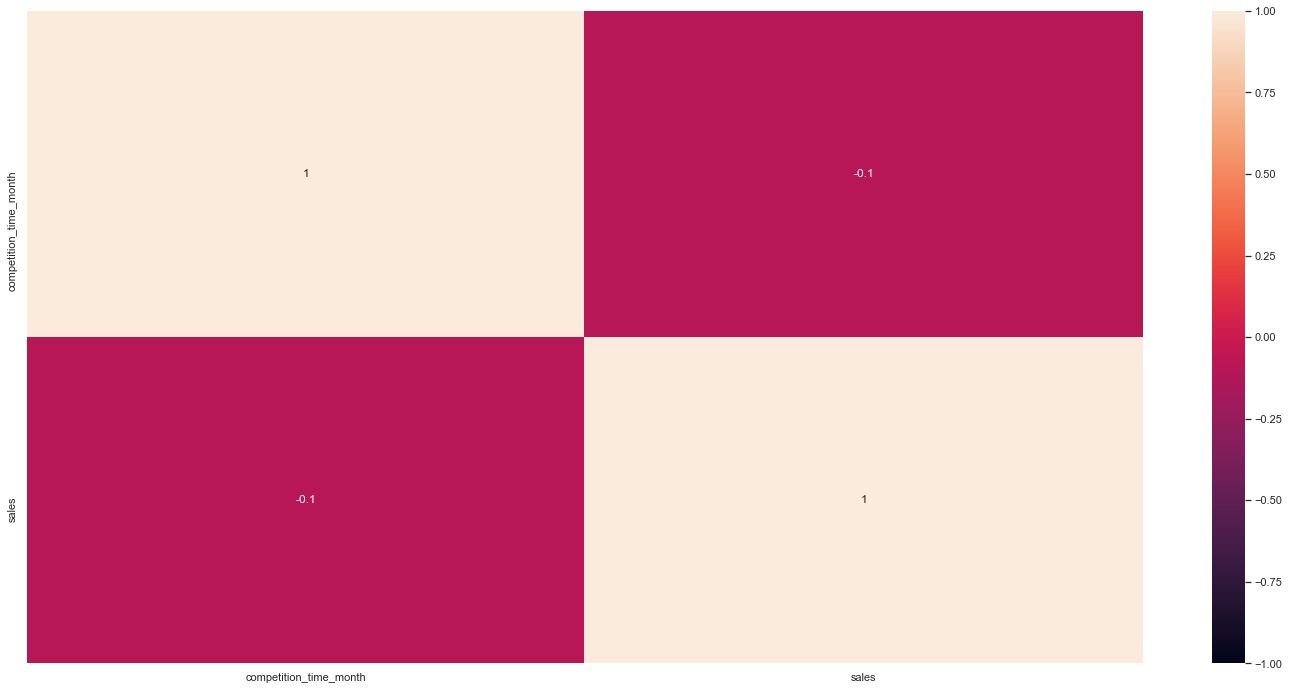

In [58]:
aux1 = df4[['competition_time_month',
            'sales']].groupby(['competition_time_month']).sum().reset_index()
aux2 = aux1.query('competition_time_month < 120 & competition_time_month != 0')
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90)
plt.show()
#---
sns.heatmap(aux1.corr(method='pearson'), annot=True, vmin=-1)
plt.show()

### Loja-H4. Lojas com promoções ativas por mais tempo deveriam vender mais
**FALSA**: Lojas com PROMOÇÕES ATIVAS POR MAIS TEMPO vendem MENOS, depois de um certo periodo de promoção

In [59]:
# promo_time_week foi calculada como a diferença entre a data da compra - a data do inicio da promo 2 (entensão)
# promo_time_week negativo significa que está em periodo de promoção regular. Se positivo, então está no periodo de promo estendida

<AxesSubplot:>

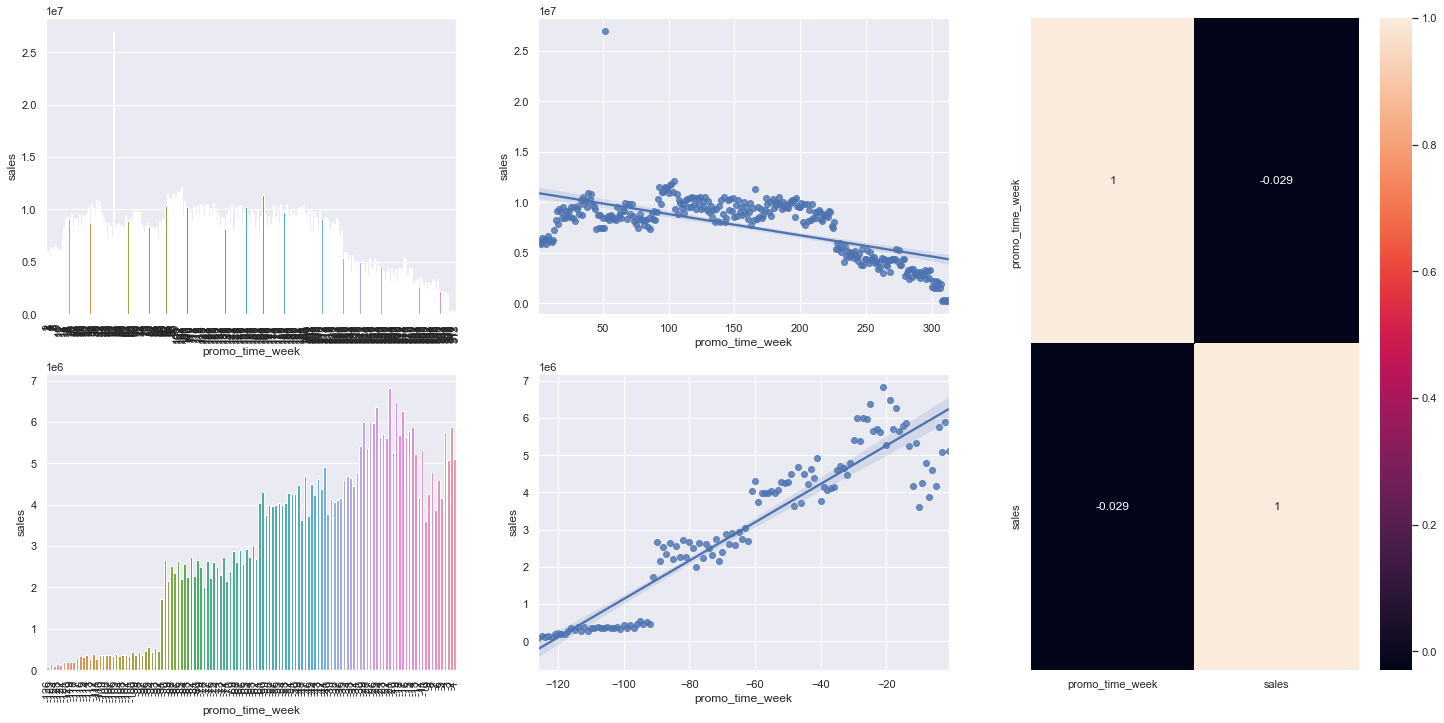

In [60]:
aux1 = df4[['promo_time_week',
            'sales']].groupby('promo_time_week').sum().reset_index()

# para ter mais liberdade para montar o grid de subplots
gd = GridSpec(2, 3)

plt.subplot(gd[0, 0])
aux2 = aux1.query('promo_time_week > 0')  # promo estendida
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(gd[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

#---
plt.subplot(gd[1, 0])
aux3 = aux1.query('promo_time_week < 0')  # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90)

plt.subplot(gd[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

#---
plt.subplot(gd[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### ~~Loja-H5. Lojas com mais dias de promoção deveriam vender mais~~
**(Precisará de mais processamentos no dataset, então deixaremos para o proximo ciclo)**

### Loja-H6. Lojas com mais promoções consecutivas deveriam vender mais
**FALSA**: Lojas com promoções consecutivas vendem MENOS

In [61]:
aux1 = df4[['promo', 'promo2',
            'sales']].groupby(['promo', 'promo2']).sum().reset_index()
aux1.sort_values('sales')

# result: Aparentemente não há vantagem em fazer a promo2

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


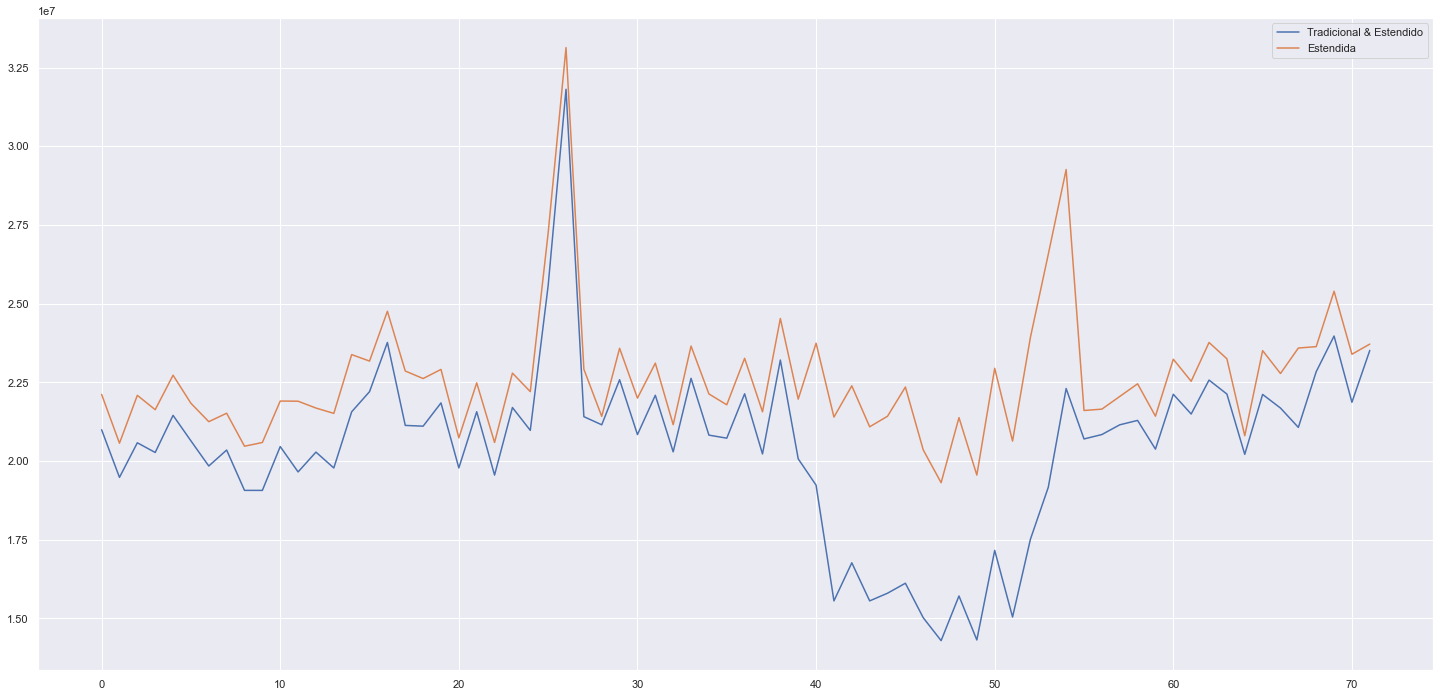

In [62]:
aux1 = df4.query('promo == 1 & promo2 == 1')[[
    'year_week', 'sales'
]].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4.query('promo == 1 & promo2 == 0')[[
    'year_week', 'sales'
]].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

plt.legend(labels=['Tradicional & Estendido', 'Estendida'])

# Result: Em geral o comportamento é igual dos dois gráficos, apenas possuem magnitudes diferentes

### Loja-H7. Lojas abertas durante o feriado de natal deveriam vender mais.
**FALSA**: Lojas abertas durante o feriado de natal vendem menos. (considerando valores absolutos de vendas isso é bem óbvio, pois há apenas 1 dia de natal)

<AxesSubplot:xlabel='year', ylabel='sales'>

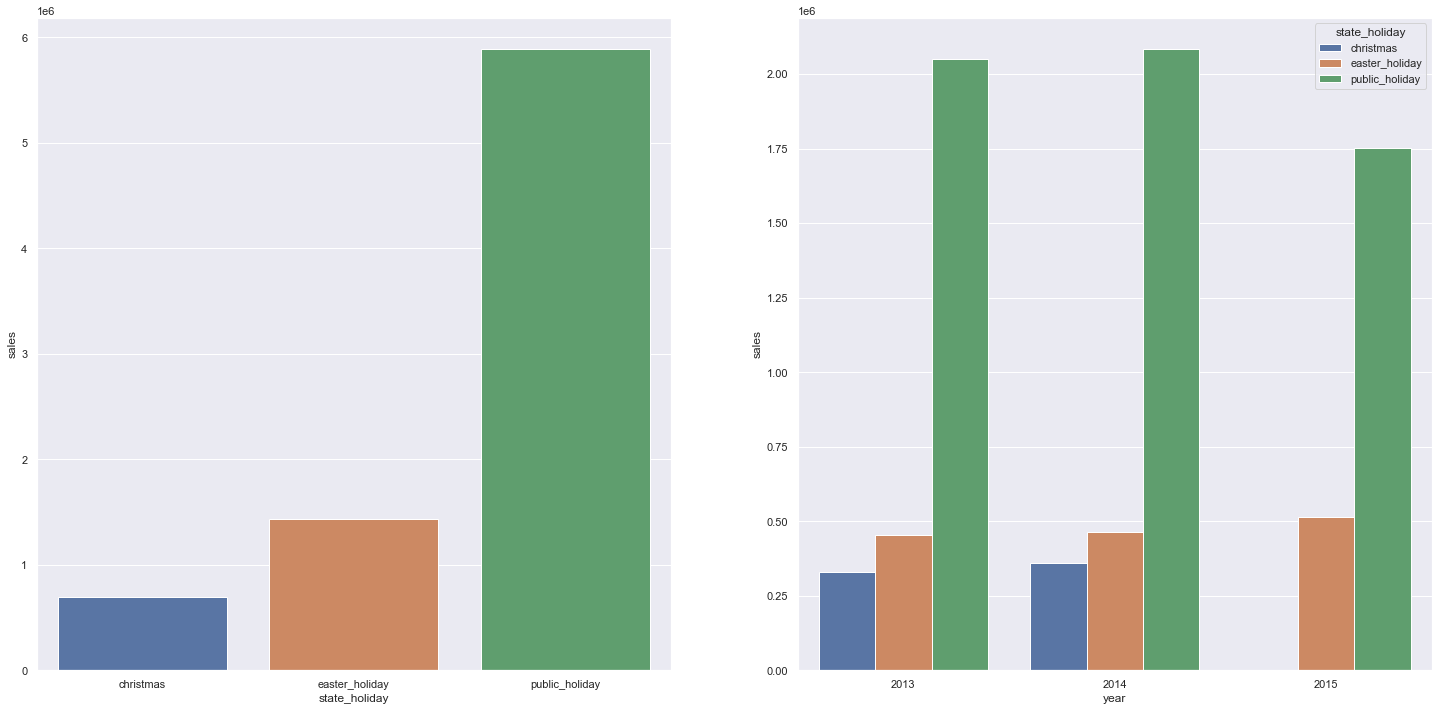

In [63]:
aux = df4.query('state_holiday != "regular_day"')

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday',
            'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday',
            'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', hue='state_holiday', y='sales', data=aux2)

### Loja-H8. Lojas deveriam vender mais ao longo dos anos.
**FALSA**: Lojas vendem menos ao longo dos anos (considerando apenas 2013 e 2014, pois 2015 está incompleto)

<AxesSubplot:>

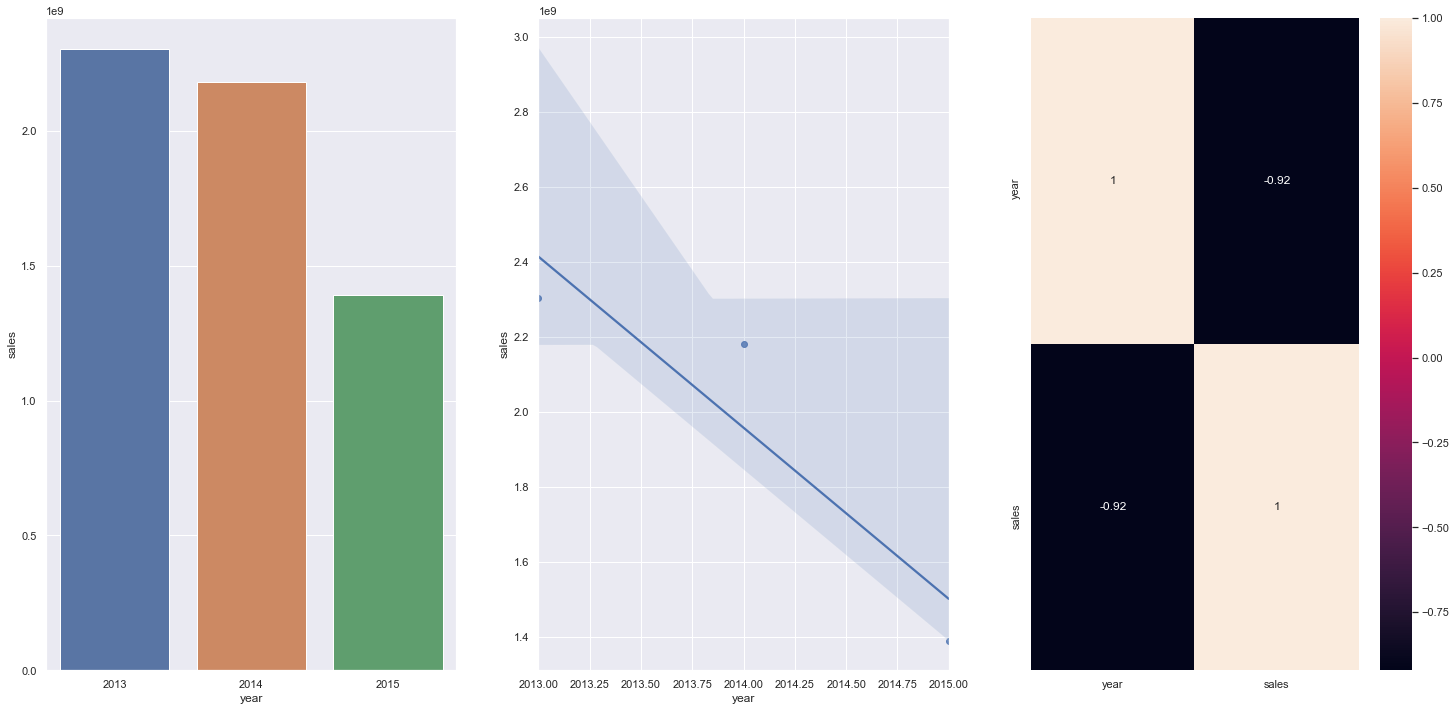

In [64]:
# Na vida real sempre pegar periodos fechados, pois periodos ainda não terminados como 2015 nesse ds, podem impactar nas análises

aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### Loja-H9. Lojas deveriam vender mais no segundo semestre do ano.
**FALSA**: Lojas vendem menos no segundo semestre do ano

<AxesSubplot:>

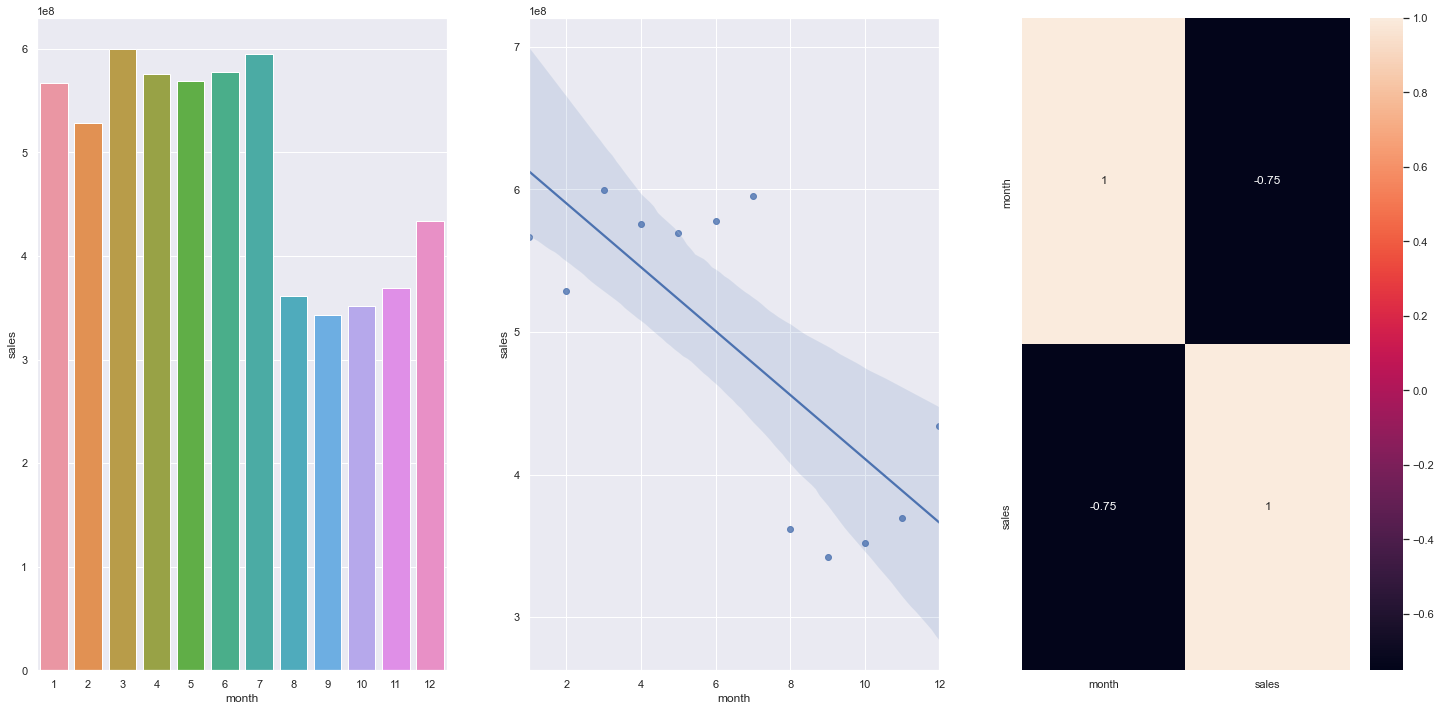

In [65]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### Loja-H10. lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA**: Lojas vendem mais depois do dia 10 de cada mês (O que é bem obvio, pois, vendas de 10 dias está em uma ordem diferente de vendas de 20 dias)

<AxesSubplot:xlabel='before_after', ylabel='sales'>

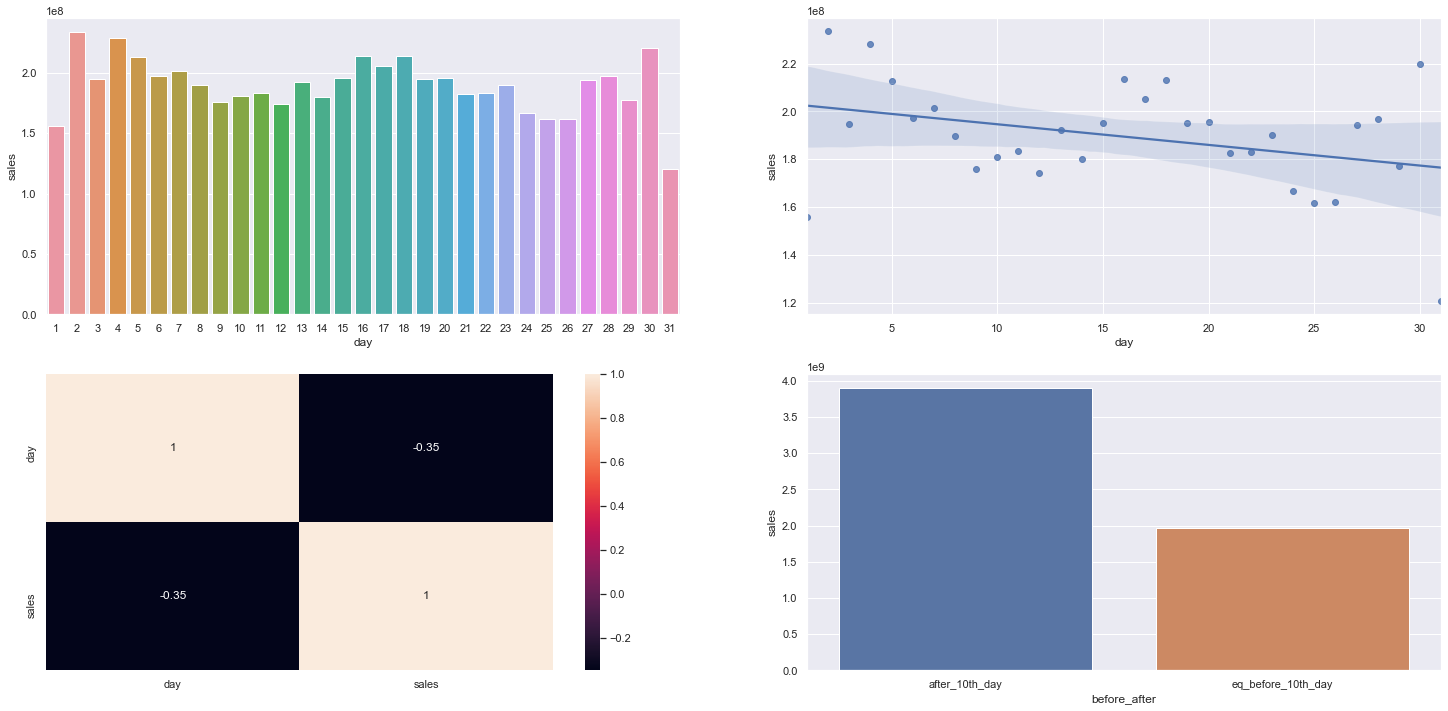

In [66]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'eq_before_10th_day'
                                         if x <= 10 else 'after_10th_day')
aux2 = aux1[['before_after',
             'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2)

### Loja-H11. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA**: Lojas vendem menos nos finais de semana (porém a média e mediana de vendas do final de semana serem maiores)

<AxesSubplot:>

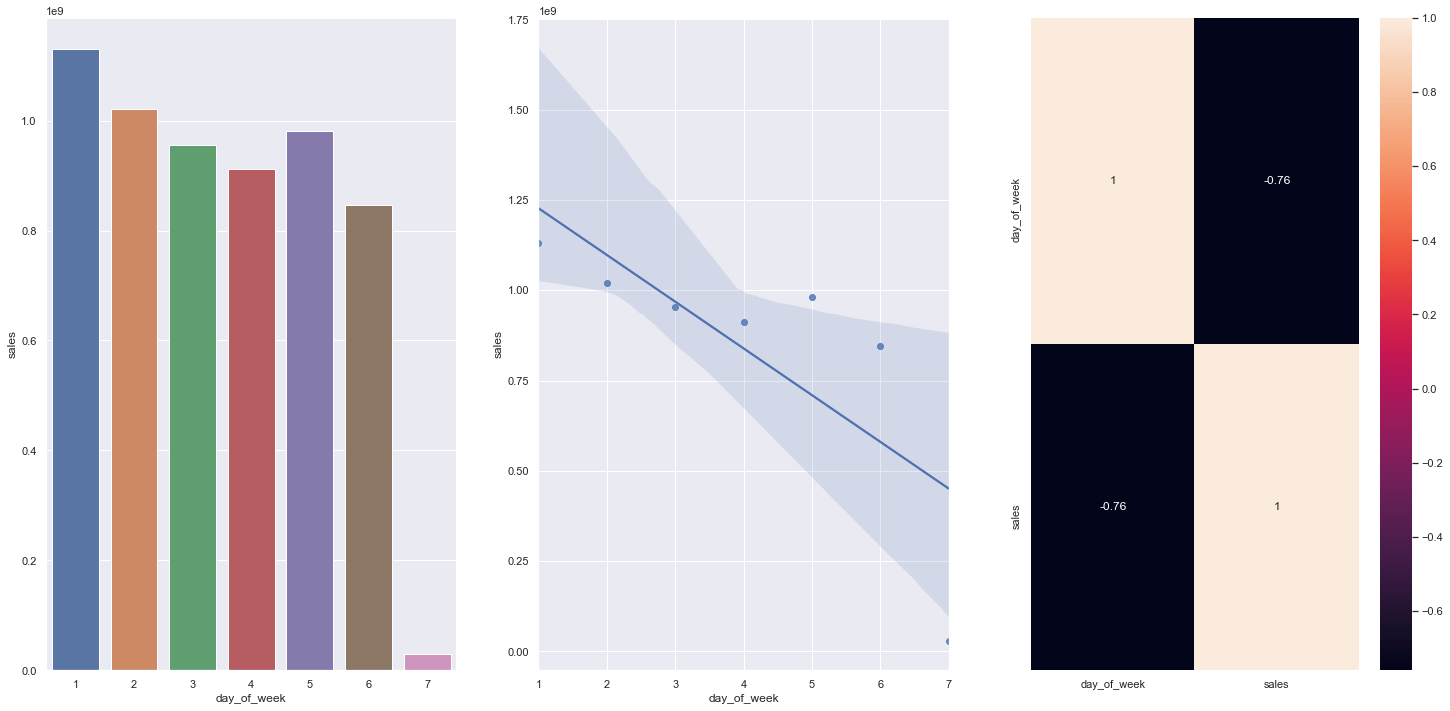

In [67]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

> Sabemos que apenas algumas lojas ficam abertas no domingo,logo seria melhor fazer uma análise separada para essas lojas

### Loja-H12. Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA**: Lojas vendem menos durante os feriados escolares, exceto nos meses de julho e agosto (Férias) 

<AxesSubplot:xlabel='month', ylabel='sales'>

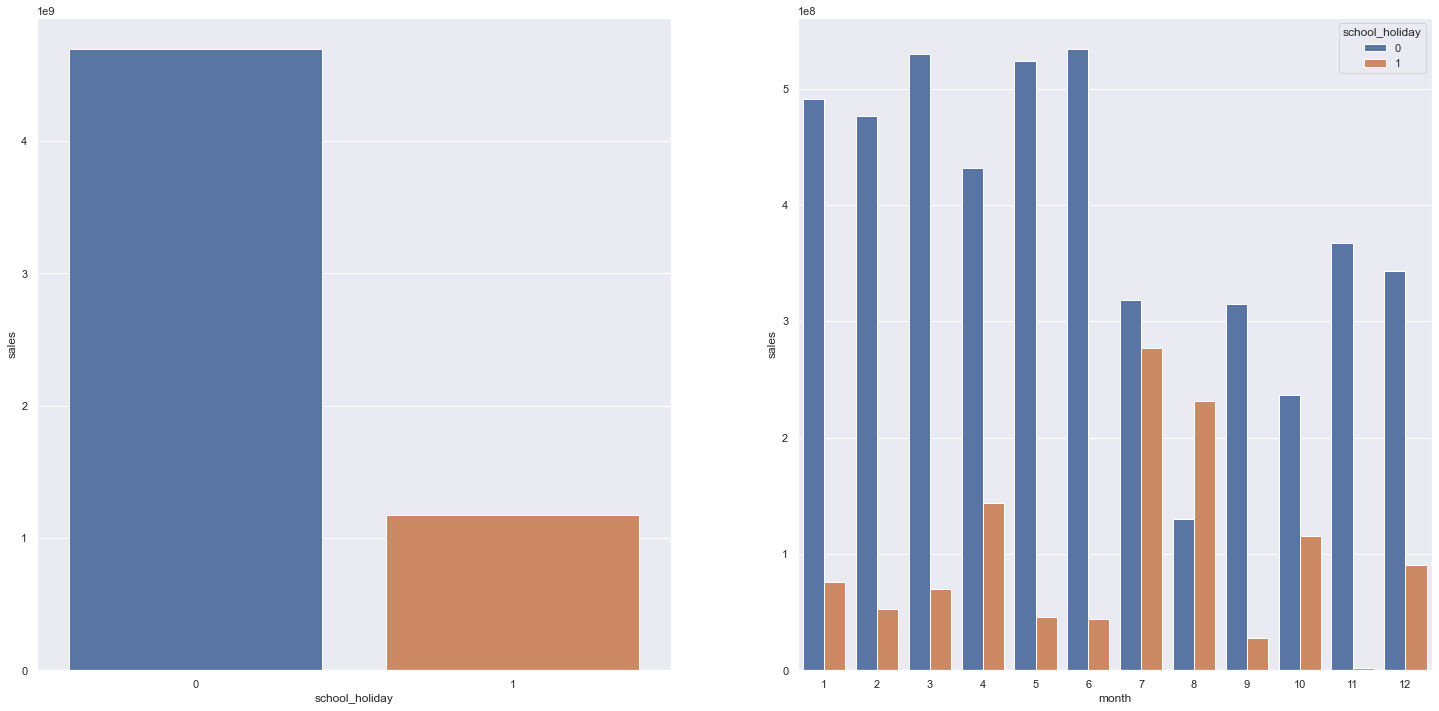

In [68]:
aux1 = df4[['school_holiday',
            'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(1, 2, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

aux2 = df4[['month', 'school_holiday',
            'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(1, 2, 2)
sns.barplot(x='month', hue='school_holiday', y='sales', data=aux2)

### 4.2.1. Resumo das Hipoteses

In [69]:
from tabulate import tabulate

tab = [
    ['Hipoteses', 'Conclusao', 'Relevancia'],
    ['H1', 'Falsa', 'Baixa'],
    ['H2', 'Falsa', 'Media'],
    ['H3', 'Falsa', 'Media'],
    ['H4', 'Falsa', 'Baixa'],
    ['H5', '-', '-'],
    ['H6', 'Falsa', 'Baixa'],
    ['H7', 'Falsa', 'Media'],
    ['H8', 'Falsa', 'Alta'],
    ['H9', 'Falsa', 'Alta'],
    ['H10', 'Verdadeira', 'Alta'],
    ['H11', 'Verdadeira', 'Alta'],
    ['H12', 'Verdadeira', 'Baixa'],
]
print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 - Análise Multivariada 

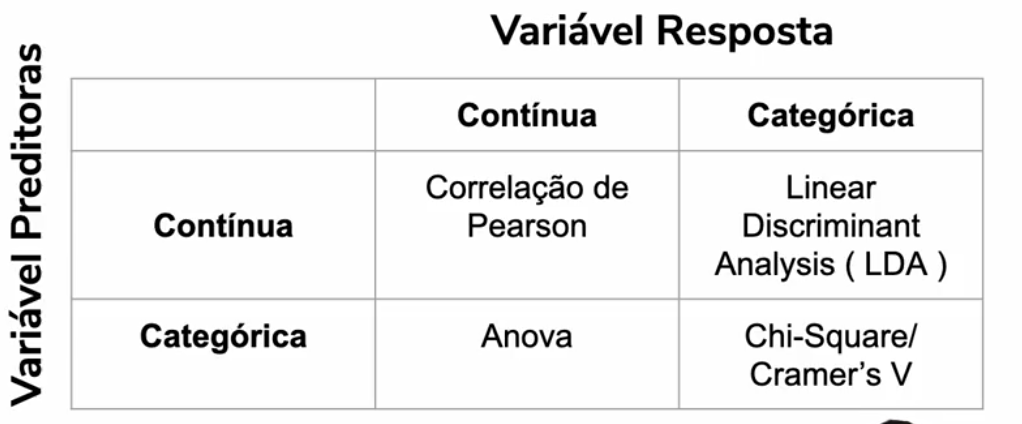
> **Quadro resumo correlações**

### 4.3.1 - Numerical Attributes

<AxesSubplot:>

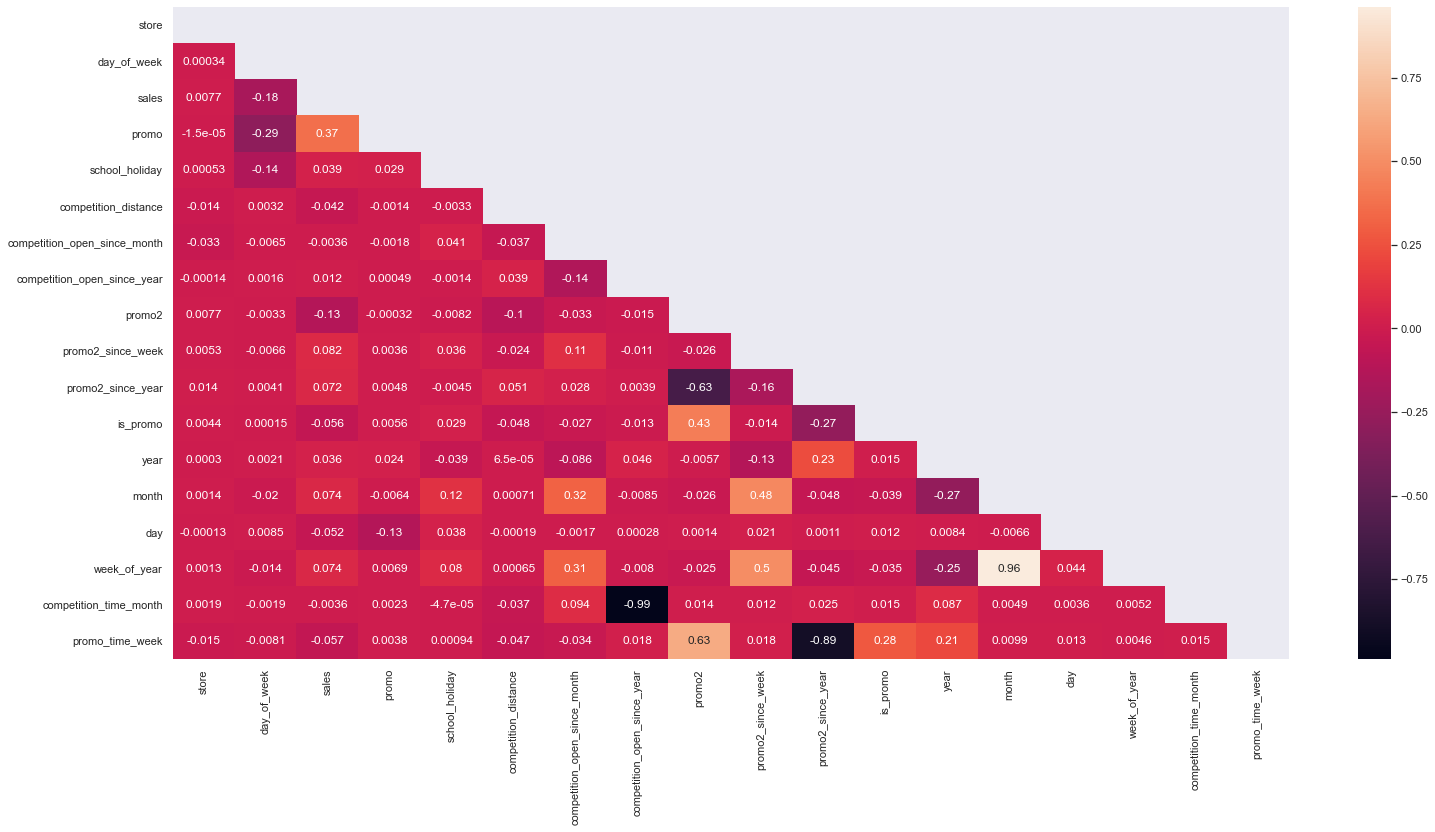

In [70]:
correlation = num_attributes_df4.corr(method='pearson')

mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(correlation, annot=True, mask=mask)

### 4.3.2 - Categorical Attributes

<AxesSubplot:>

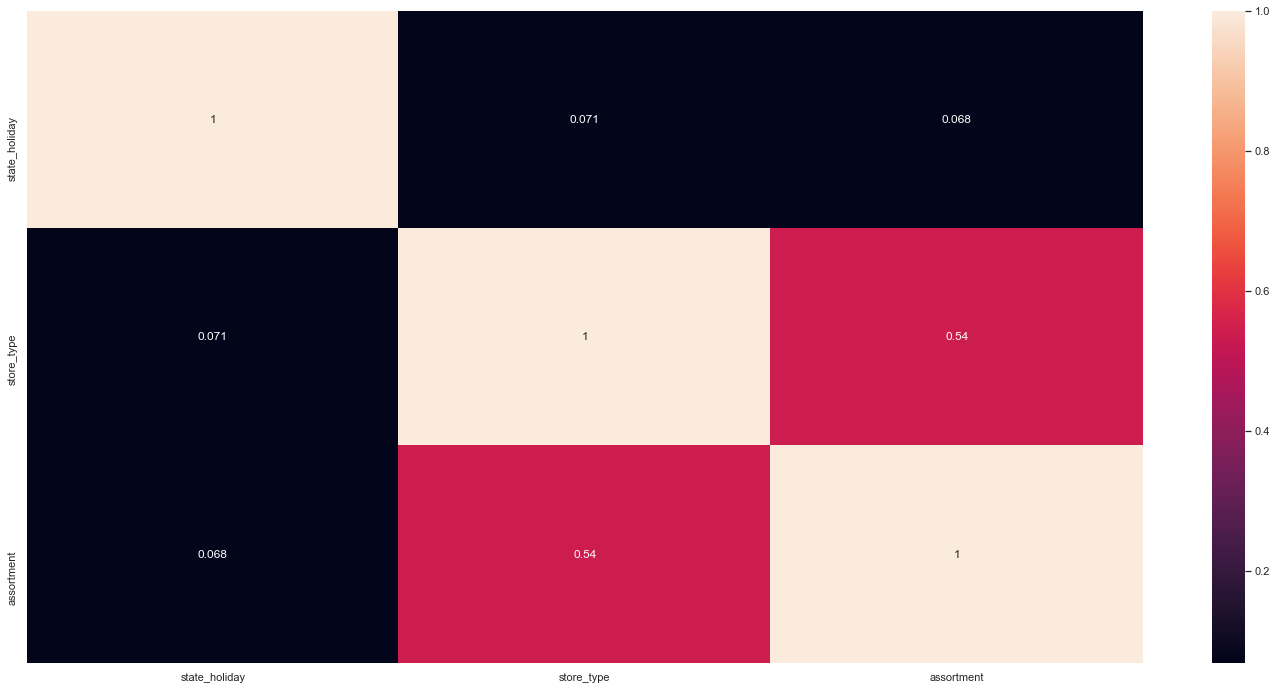

In [71]:
corr_dict = {}

cols = ['state_holiday', 'store_type', 'assortment']
# faz um combinação entre todas as colunas para gerar a matriz de correlação
for x in cols:
    corr_dict[x] = []
    for y in cols:
        corr_dict[x].append(
            cramer_v(cat_attributes_df4[x], cat_attributes_df4[y]))

df_corr = pd.DataFrame(corr_dict)
df_corr = df_corr.set_index(df_corr.columns)

sns.heatmap(df_corr, annot=True)

# 5.0 - PREPARAÇÃO DOS DADOS

In [11]:
try:
    df5 = df4.copy()
    joblib.dump(df5, "data/full_training_before_split.joblib.bz2")
except:
    df5 = joblib.load("data/full_training_before_split.joblib.bz2")

## 5.0.1 - Split DataFrame into training and test dataset

> Para dividir os dados de time series, é necessário separar em periodos sequenciais (ex: Antes de 01/06/2014 e Depois de 01/06/2014)

Aqui iremos utilizar as **6 últimas semanas como teste (validação)**, já que esse é o objetivo final

In [12]:
# obtendo data maxima e minima dos dados
min_max_date = (df5[['store','date']]
                .groupby('store')
                .agg(['min','max'])
                .drop_duplicates([('date', 'min'),('date', 'max')]))

"De {:%Y-%m-%d} até {:%Y-%m-%d}".format(df5["date"].min(), df5["date"].max())

'De 2013-01-01 até 2015-07-31'

In [13]:
# subtraindo 6 semanas da data máxima
threshold_date = (min_max_date.loc[:, ('date','max')].max() - dt.timedelta(weeks=6))
threshold_date

Timestamp('2015-06-19 00:00:00')

In [14]:
# Training dataset
X_train_ = df5.query('date < @threshold_date')
y_train_ = X_train_['sales']

# Test dataset
X_test_ = df5.query('date >= @threshold_date')
y_test_ = X_test_['sales']

X_train_.drop(columns="sales", inplace=True)
X_test_.drop(columns="sales", inplace=True)

print("Training Min date={} | Max date={}".format(X_train_['date'].min(),
                                                  X_train_['date'].max()))
print("Test Min date={} | Max date={}".format(X_test_['date'].min(),
                                              X_test_['date'].max()))

Training Min date=2013-01-01 00:00:00 | Max date=2015-06-18 00:00:00
Test Min date=2015-06-19 00:00:00 | Max date=2015-07-31 00:00:00


In [15]:
X_train_.shape[0], X_test_.shape[0]

(802942, 41396)

## 5.1 - Normalização

> OBS: Não existe nenhuma feature com distribuição normal ou próxima de uma normal, logo não iremos fazer normalização. 

## 5.2 - Rescaling

> De modo geral: Aplicar **Min-Max Scaler** quando a coluna não possuir muitos outliers e caso contrário aplicar **Robust Scaler** 

#### 1.Separar as variaveis para o scaling:

In [16]:
vars_to_scaling = [
    'competition_distance',  # muitos outliers => Robust Scaler
    'competition_time_month',  # muitos outliers => Robust Scaler
    'promo_time_week',  # poucos outliers => MinMax Scaler
    'year',  # sem outliers => MinMax Scaler
    'promo2_since_week', # sem outliers => MinMax Scaler
    'promo2_since_year', # sem outliers => MinMax Scaler
    'competition_open_since_year' # poucos outliers => MinMax Scaler
]

#### 2. Gerar o boxplot de cada variável e analisar os outliers 

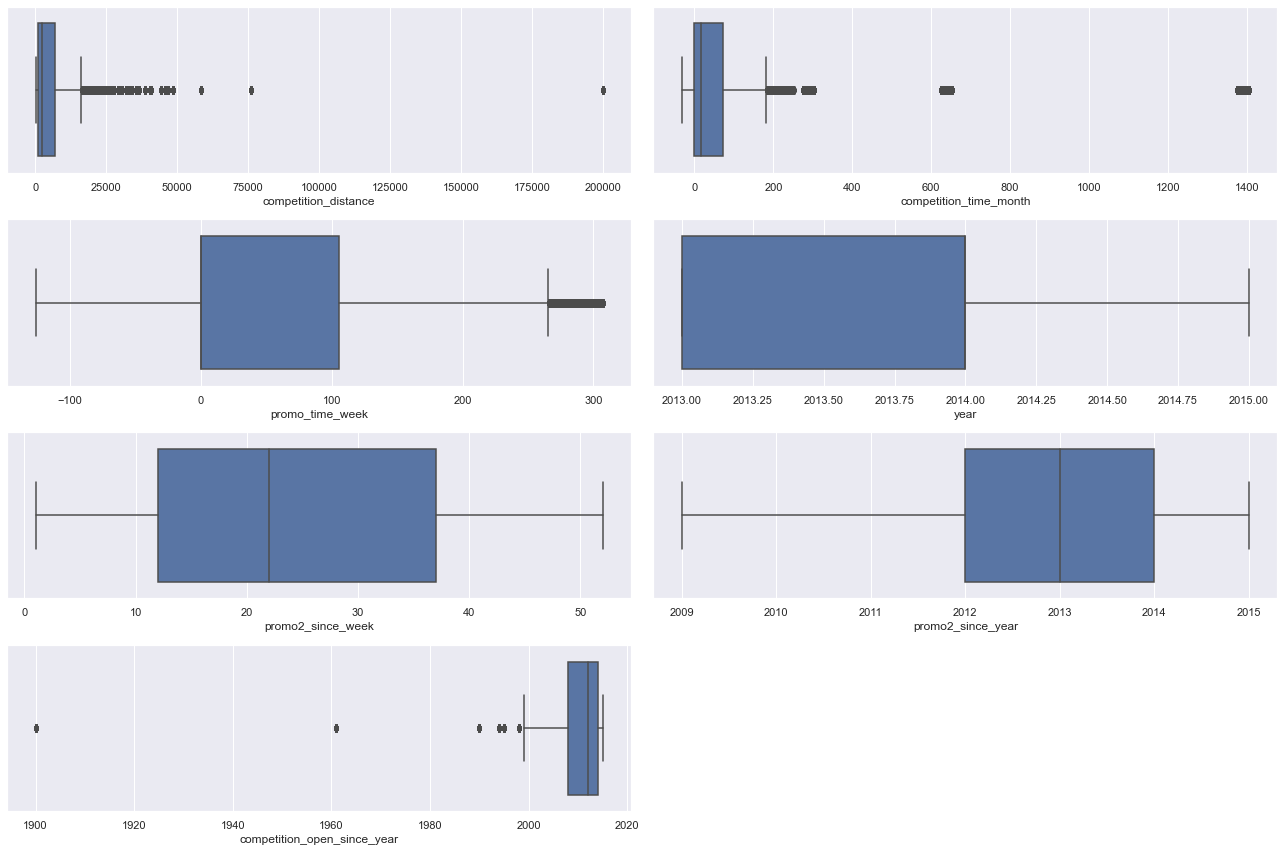

In [9]:
len_cols = len(vars_to_scaling)
plt.figure(figsize=(18, 12))
for i, col in enumerate(vars_to_scaling, start=1):
    plt.subplot(len_cols//2+1, 2, i)
    sns.boxplot(x=col, data=X_train_[vars_to_scaling])
plt.tight_layout()

#### 3. Aplicar os scalers

In [17]:
def apply_scaler(scaler, col_name, save_parameter=True):
    X_train_[col_name] = scaler.fit_transform(X_train_[[col_name]].values)
    X_test_[col_name] = scaler.transform(X_test_[[col_name]].values)
#     if save_parameter:
#         joblib.dump(scaler, f'parameter/{col_name}_scaler.pkl.bz2')

In [18]:
# Robust scaler: possuem muitos outliers
rs = RobustScaler()
apply_scaler(rs, 'competition_distance')
apply_scaler(rs, 'competition_time_month')

# MinMax scaler: Não possuem outliers, ou possuem poucos
mms = MinMaxScaler()
apply_scaler(mms, 'promo_time_week')
apply_scaler(mms, 'year')
apply_scaler(mms, 'promo2_since_year')
apply_scaler(mms, 'competition_open_since_year')
apply_scaler(mms, 'promo2_since_week')

In [19]:
X_train_[vars_to_scaling].describe()

,competition_distance,competition_time_month,promo_time_week,year,promo2_since_week,promo2_since_year,competition_open_since_year
count,802942.000000,802942.000000,802942.000000,802942.000000,802942.000000,802942.000000,802942.000000
mean,0.585801,0.344316,0.412555,0.385863,0.441459,0.628263,0.959242
std,2.030069,0.911109,0.193729,0.374610,0.283325,0.272515,0.047659
min,-0.372581,-0.657534,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.261290,-0.219178,0.290993,0.000000,0.215686,0.500000,0.939130
50%,0.000000,0.000000,0.290993,0.500000,0.411765,0.666667,0.973913
75%,0.738710,0.780822,0.535797,0.500000,0.705882,0.833333,0.991304
max,31.882258,19.027397,1.000000,1.000000,1.000000,1.000000,1.000000


## 5.3 - Transformações

### 5.3.1 - Encoding

In [20]:
X_train_[["state_holiday", "store_type", "assortment"]].apply(lambda x: ", ".join(x.unique()))

state_holiday    regular_day, public_holiday, easter_holiday, c...
store_type                                              c, a, d, b
assortment                                  basic, extended, extra
dtype: object

> É necessário muito cuidado ao utilizar __get_dummies__ em produção, pois quando os dados novos não possuem todas as categorias, ficará faltando features no novo dataset \([Ref](https://thenewstack.io/machine-learning-in-production-lessons-learned-from-deploying-our-first-ml-model/)) . A melhor solução é utilizar __OneHotEncoder__ do sklearn (para utilizar os mesmos parametros dos dados de treino)

In [24]:
def apply_onehot(encoder, col_name):
    global X_train_, X_test_
    tr = encoder.fit_transform(X_train_[[col_name]].values)
    
    columns = [*map(lambda c: col_name+"_"+c, encoder.categories_[0])]
    X_train_ = X_train_.join(pd.DataFrame(tr.toarray(), columns=columns, index=X_train.index))
    
    te = encoder.transform(X_test_[[col_name]].values)
    X_test_ = X_test_.join(pd.DataFrame(te.toarray(), columns=columns, index=X_test.index))

In [25]:
# state_holiday => OneHotEncoder
oh = OneHotEncoder()
apply_onehot(oh, "state_holiday")

# store_type => OneHotEncoder
apply_onehot(oh, "store_type")

In [26]:
# # assortment -> Possui uma ordem implicita (Considerei que possui uma ordem na EDA, 
#    então manterei dessa forma), logo utilizar Ordinal Encoding
oe = OrdinalEncoder(categories=[['basic', 'extended', 'extra']])
X_train_["assortment"] = oe.fit_transform(X_train_[["assortment"]].values)
X_test_["assortment"] = oe.transform(X_test_[["assortment"]].values)

### 5.3.2 - Response Variable Transformation

In [27]:
# Transformação logaritmica # log1p = ln(x+1)  que é inverso de expm1 = exp(x)-1
y_train = np.log1p(y_train_)  
y_test = np.log1p(y_test_)  

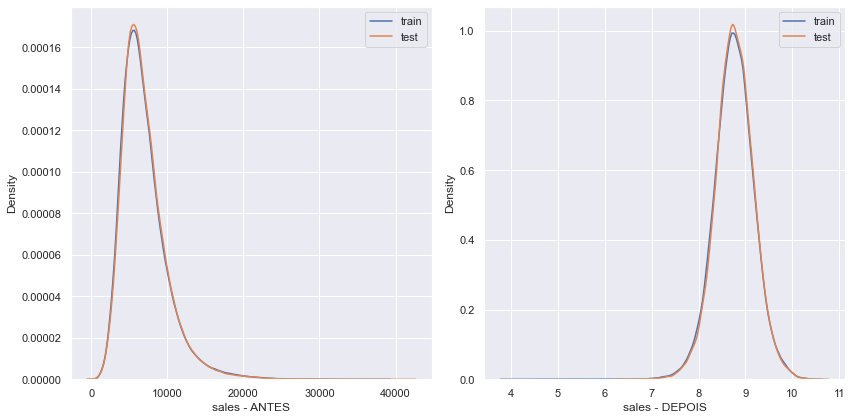

In [28]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.distplot(y_train_, hist=False, label="train")
sns.distplot(y_test_, hist=False, axlabel="sales - ANTES", label="test")
plt.tight_layout()
plt.legend()

plt.subplot(1, 2, 2)
sns.distplot(y_train, hist=False, label="train")
sns.distplot(y_test, hist=False, axlabel="sales - DEPOIS", label="test")

plt.tight_layout()
plt.legend()
plt.show()

### 5.3.3 - Nature Transformation

In [29]:
# Variáveis que possuem uma natureza ciclica e que devem ser modificadas

def cyclic_transform(df, col, n):
    """
    Transforma a coluna `col` do dataframe `df` em uma forma cíclica com seno e cosseno. 
    X * (2 * pi / n) converte os valores para radiano 
    `n` é a quantidade de níveis.
        [Ref](https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/)
    """
    df[col + '_sin'] = np.sin(df[col].values * (2 * np.pi / n))
    df[col + '_cos'] = np.cos(df[col].values * (2 * np.pi / n))


for df in [X_train_, X_test_]: 
    # day_of_week
    cyclic_transform(df, 'day_of_week', 7)

    # month
    cyclic_transform(df, 'month', 12)

    # day
    cyclic_transform(df, 'day', 30)  # utilizando calendario comercial de 30 dias

    # week_of_year
    cyclic_transform(df, 'week_of_year', 52)

### Deletar variaveis que foram utilizadas para derivar outras

In [30]:
cols_drop = [
    'week_of_year', 'day', 'month', 'day_of_week', 'promo_since',
    'competition_since', 'year_week', 'state_holiday', 'store_type'
]
X_train = X_train_.drop(cols_drop, axis=1)
X_test = X_test_.drop(cols_drop, axis=1)

### Dimensões dos datasets transformados

In [31]:
print("linhas: Treino = {tr[0]} | Teste = {te[0]}\nNº de features: {tr[1]}".format(tr=X_train.shape, te=X_test.shape))

linhas: Treino = 802942 | Teste = 41396
Nº de features: 31


In [34]:
joblib.dump(X_train, "data/X_train_transformed.joblib.bz2")
joblib.dump(X_test, "data/X_test_transformed.joblib.bz2")

joblib.dump(y_train, "data/y_train_transformed.joblib.bz2")
joblib.dump(y_test, "data/y_test_transformed.joblib.bz2")

['data/y_test_transformed.joblib.bz2']

# 6.0 - FEATURE SELECTION

In [4]:
try:
    display(X_train.columns)
except NameError:
    X_train = joblib.load("data/X_train_transformed.joblib.bz2") 
    X_test = joblib.load("data/X_test_transformed.joblib.bz2")
    y_train = joblib.load("data/y_train_transformed.joblib.bz2") 
    y_test = joblib.load("data/y_test_transformed.joblib.bz2")
    display(X_train.columns)

Index(['store', 'date', 'promo', 'school_holiday', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'is_promo', 'year', 'competition_time_month',
       'promo_time_week', 'state_holiday_christmas',
       'state_holiday_easter_holiday', 'state_holiday_public_holiday',
       'state_holiday_regular_day', 'store_type_a', 'store_type_b',
       'store_type_c', 'store_type_d', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos'],
      dtype='object')

## 6.1 - Boruta as a Feature Selector

Pode ser utilizado com qualquer modelo _tree-based_, como Random Forest, XGBoost, etc.

In [5]:
#training and test dataset for Boruta
X_train_n = X_train.drop(['date'], axis=1).values
y_train_n = y_train.values.ravel()

# Se não foi possivel ler o arquivo pickle com colunas selecionadas, então executa o boruta
try:
    cols_selected_boruta = joblib.load("parameter/cols_selected_boruta_rf.pkl.bz2")
    print("cols_selected_boruta carregado em memória.")
except FileNotFoundError:
    # #define RandomForestRegressor
    est = RandomForestRegressor(n_jobs=-1, random_state=42, max_depth=6)
#     est = XGBRegressor(gpu_id=0, tree_method="gpu_hist")

    print("Executando Boruta Feature Selector")

    #Define Boruta (rodar apenas uma vez. Resultado da seleção foi persistido em disco)
    boruta = BorutaPy(est, n_estimators='auto', verbose=2, random_state=42)
    boruta.fit(X_train_n, y_train_n)

cols_selected_boruta carregado em memória.


Observações
- Boruta com XGBoost, não descartou nenhuma coluna;
- Boruta com RF descartou 6 features

### 6.2.1 - Best features from Boruta

> Usaremos apenas as variáveis que o boruta sugeriu, mesmo que alguma esteja em contradição com nossas hipóteses com alta relevância.\
> Adicionaremos apenas aquelas que são complementares, como month_sin e month_cos, etc.

> Para o proximo ciclo podemos adicionar essas outras variaveis que achamos importantes com as hipóteses levantadas na seção 4.

In [44]:
# retorna um array com o indice das colunas selecionadas
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop(['date'],axis=1)

# pegando os nomes das colunas que o boruta selecionou
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()  

# atributos que foram descartados pelo boruta
diff_cols = np.setdiff1d(X_train_fs.columns, cols_selected_boruta)
cols_not_selected_boruta = list(diff_cols)

### 6.2.2 - Colunas Selecionadas

In [9]:
cols_selected_boruta

['assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'competition_time_month',
 'date',
 'day_cos',
 'day_of_week_cos',
 'day_of_week_sin',
 'day_sin',
 'is_promo',
 'month_cos',
 'promo',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'promo_time_week',
 'school_holiday',
 'store',
 'store_type_a',
 'store_type_b',
 'store_type_c',
 'store_type_d',
 'week_of_year_cos',
 'week_of_year_sin']

### 6.2.3 -  Colunas Rejeitadas

In [45]:
cols_not_selected_boruta

['month_sin',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'year']

### 6.2.4 - Manual Feature Selection
> Associar o conhecimento que temos dos dados com a resposta do Boruta

1. Olhar a tabela resumo de hipóteses e verificar as variáveis/hipoteses que possuem relevância alta. 
2. Caso o Boruta esteja em contradição com essas informações, é papel do CD decidir o que fazer.

In [21]:
# Adicionando colunas manualmente 
cols_selected_boruta += ['state_holiday_regular_day', 'month_sin']

In [565]:
joblib.dump(cols_selected_boruta, "parameter/cols_selected.pkl.bz2")

['parameter/cols_selected.pkl.bz2']

In [46]:
len(cols_selected_boruta)

26

# 7.0 - MACHINE LEARNING MODELLING

#### (Pre Loads)

In [564]:
cols_selected_boruta_ = joblib.load("parameter/cols_selected.pkl.bz2")
print("cols_selected_boruta carregado em memória.")

cols_selected_boruta_extended = cols_selected_boruta_ + ["date"]
cols_selected_boruta = cols_selected_boruta_

cols_selected_boruta carregado em memória.


In [9]:
# df apenas com as features selecionadas (e tbm sem data)
x_train = X_train[cols_selected_boruta]

x_test = X_test[cols_selected_boruta]

## 7.1 - Baseline Model

In [51]:
# df auxiliar para calcular o modelo de média
aux_xtest = x_test.copy()
aux_xtest['sales'] = y_test.copy()

# prediction
aux_xtest2 = (aux_xtest[['store','sales']].groupby('store')
              .mean().reset_index()
              .rename(columns={'sales': 'predictions'}))

aux_xtest = pd.merge(aux_xtest, aux_xtest2, how='left', on='store')

y_hat_baseline = aux_xtest['predictions']

# performance
baseline_result = helpers.ml_error("Average Model", np.expm1(y_test), np.expm1(y_hat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE,RMSPE,MPE
0,Average Model,1354.800353,0.455051,1835.135542,0.705015,-0.131769


## 7.2 - Linear Regression Model

In [54]:
# MODEL
lr = LinearRegression()
lr.fit(x_train, y_train)

# PREDICTION
y_hat_lr = lr.predict(x_test)

# PERFORMANCE
lr_result = helpers.ml_error("Linear Regression", np.expm1(y_test), np.expm1(y_hat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE,RMSPE,MPE
0,Linear Regression,1852.135802,0.290542,2633.316544,0.426468,-0.080563


## 7.3 - Linear Regression Regularized Model - Lasso

In [55]:
# MODEL
lrr = Lasso(alpha=0.01, random_state=42)
lrr.fit(x_train, y_train)

# PREDICTION
y_hat_lrr = lrr.predict(x_test)

# PERFORMANCE
lrr_result = helpers.ml_error("Lasso", np.expm1(y_test), np.expm1(y_hat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE,RMSPE,MPE
0,Lasso,1900.68588,0.288705,2767.382067,0.421776,-0.051796


## 7.4 - Random Forest Regressor

In [56]:
# MODEL
rf = RandomForestRegressor(n_jobs=-1, random_state=42)
rf.fit(x_train, y_train)

# PREDICTION
y_hat_rf = rf.predict(x_test)

# PERFORMANCE
rf_result = helpers.ml_error("Random Forest Regressor", np.expm1(y_test), np.expm1(y_hat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE,RMSPE,MPE
0,Random Forest Regressor,669.251942,0.099238,1000.61791,0.139961,-0.021941


## 7.5 - XGBoost Regressor

In [57]:
model_xgb = XGBRegressor(gpu_id=0, tree_method="gpu_hist")
model_xgb.fit(x_train, y_train)

# PREDICTION
y_hat_xgb = model_xgb.predict(x_test)

# PERFORMANCE
xgb_result = helpers.ml_error("XGBoost Regressor", np.expm1(y_test), np.expm1(y_hat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE,RMSPE,MPE
0,XGBoost Regressor,878.87491,0.131862,1257.3219,0.181767,-0.017294


## 7.6 - Comparando as performances dos modelos

### 7.6.1 - Single Performance

In [62]:
modelling_result_list = [
    baseline_result, lr_result, lrr_result, rf_result, xgb_result
]
modelling_result = pd.concat(modelling_result_list)
modelling_result.sort_values("RMSE")

,Model Name,MAE,MAPE,RMSE,RMSPE,MPE
0,Random Forest Regressor,669.251942,0.099238,1000.617910,0.139961,-0.021941
0,XGBoost Regressor,878.874910,0.131862,1257.321900,0.181767,-0.017294
0,Average Model,1354.800353,0.455051,1835.135542,0.705015,-0.131769
0,Linear Regression,1852.135802,0.290542,2633.316544,0.426468,-0.080563
0,Lasso,1900.685880,0.288705,2767.382067,0.421776,-0.051796


### 7.6.2 - REAL Performance - Cross Validation for Time series

O método utilizado para estimar as performances reais dos modelos e que preserva a ordem temporal das observações é chamado de validação cruzada para séries temporais ou Out-Of-Sample (OOS). Onde os dados separados para treinamento serão sempre de datas anteriores ao conjunto de validação.\
Existem algumas variantes dessa estratégia, então deixei as referências para consulta.\
A estratégia que escolhi para esse projeto é chamada de [Prequential Expanding][3]. Abaixo criei uma gráfico mostrando como os dados são utilizados nesse método. As últimas 6 semanas de cada fold são utilizadas para validação. 

> [Using k fold cross validation for time series model selection][1]

>[A Comparative Study of Performance Estimation Methods for Time Series Forecasting][2]

>[Evaluating time series forecasting models][3]

[1]: https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection
[2]:https://www.researchgate.net/publication/322586715_A_Comparative_Study_of_Performance_Estimation_Methods_for_Time_Series_Forecasting
[3]: https://arxiv.org/pdf/1905.11744.pdf

<img src="img/prequential_expanding_oos.png" width=800></img>

In [9]:
training = X_train[cols_selected_boruta_extended]
training['date'].max()

Timestamp('2015-06-18 00:00:00')

In [90]:
# definindo modelos
models = {
    "LinReg":
    LinearRegression(),
    "Lasso":
    Lasso(alpha=0.01, random_state=42),
    "XGBoost":
    XGBRegressor(gpu_id=0, tree_method="gpu_hist", seed=42),
    "RF":RandomForestRegressor(n_jobs=-1, random_state=42)
}

In [ ]:
cv_results_list = []
for model_name, model in models.items():
    print(model_name)
    cv_results_list.append(
        helpers.cross_validation_ts(model,
                            training, y_train,
                            model_name=model_name,
                            verbose=True, kfold=5))
    print()

cv_results = pd.concat(cv_results_list)
cv_results

> 5-fold CV results

![Training results](img/training_results.png)


# 8.0 - HYPERPARAMETER FINE TUNING

> Inicialmente será feito o deploy no Heroku, onde os [limites da conta free][1] são baixos (512 MB de RAM), portanto devemos levar em conta essa restrição na escolha do modelo que irá para produção.\
> Modelos XGBoost costumam utilizar menos memória que modelos RF, desde que a profundidade das árvores (weak learners) e a quantidade de estimadores não sejam muito altos.

> Irei adotar o **XGBoost** como modelo que irá para produção. No ajuste fino dos hiper-parâmetros será realizado um trade-off entre qualidade do modelo e consumo de recursos (memória e tempo de carregamento).

[1]: https://www.heroku.com/pricing#containers

#### (Pre Loads)

In [3]:
try:
    print(len(cols_selected_boruta), "features")
except NameError:
    cols_selected_boruta_ = joblib.load("parameter/cols_selected.pkl.bz2")
    print("cols_selected_boruta carregado em memória.")
    print(len(cols_selected_boruta_), "features")

cols_selected_boruta_extended = cols_selected_boruta_ + ["date"]
cols_selected_boruta = cols_selected_boruta_

cols_selected_boruta carregado em memória.
26 features


In [4]:
try:
    print("Dimensões X_train:", X_train.shape)
except NameError:
    X_train = joblib.load("data/X_train_transformed.joblib.bz2") 
    X_test = joblib.load("data/X_test_transformed.joblib.bz2")
    y_train = joblib.load("data/y_train_transformed.joblib.bz2") 
    y_test = joblib.load("data/y_test_transformed.joblib.bz2")

training_dt = X_train[cols_selected_boruta_extended]
print("Dimensões traning_dt (inclui data):", training_dt.shape)

Dimensões traning_dt (inclui data): (802942, 27)


In [5]:
# df apenas com as features selecionadas (e tbm sem data)
x_train = X_train[cols_selected_boruta]

x_test = X_test[cols_selected_boruta]
print("Dimensões x_train (features selecionadas):", x_train.shape)

Dimensões x_train (features selecionadas): (802942, 26)


## 8.1 - Hyperparameters Bayesian Optimization 

>  [Otimização Bayesiana][1]

[1]: https://github.com/fmfn/BayesianOptimization

In [39]:
def xgb_cv(data, targets, **hparams):
    """XGBoost cross validation.
    Our goal is to find combinations of hyperparameters that minimzes the RMSE (or maximize -1*RMSE).
    """
    estimator = XGBRegressor(seed=42, 
                             gpu_id=0, tree_method="gpu_hist",
                             **hparams)
    
    rmse = helpers.cross_validation_ts(estimator, data, targets,
                                     "XGB", kfold=5, single_score="RMSE")
    
    return -1 * rmse

def optimize_xgb(data, targets):
    """ Apply Bayesian Optimization to XBGoost parameters."""
    
    def xgb_crossval(**hparams):
        """ Wrapper of XGBoost cross validation. """
        return xgb_cv(data=data, targets=targets,
            n_estimators=int(hparams.pop("n_estimators")),
            max_depth=int(hparams.pop("max_depth")),
            min_child_weight=int(hparams.pop("min_child_weight")),
            subsample=max(min(hparams.pop("subsample"), 0.999), 1e-3),
            **hparams
        )

    optimizer = BayesianOptimization(
        f=xgb_crossval,
        pbounds={
            "n_estimators": (500, 2501),
            "eta": (0.01, 0.9),
            "max_depth": (2, 10),
            "subsample": (0.3, 0.99),
            "colsample_bytree": (0.3, 0.9),
            "min_child_weight": (1, 5)
        },
        random_state=42,
        verbose=2
    )
#     optimizer.probe(params) # para sugerir algumas combinações de parâmetros para o otimizador
    optimizer.maximize(n_iter=25, acq="ei", xi=0.05)
    return optimizer

In [40]:
print(Colours.purple("--- Optimizing XGBoost ---"))
opt = optimize_xgb(training_dt, y_train)

--- Optimizing XGBoost ---
|   iter    |  target   | colsam... |    eta    | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -1.966e+0 |  0.5247   |  0.8561   |  7.856    |  2.993    |  812.2    |  0.4076   |
|  2        | -1.823e+0 |  0.3349   |  0.7809   |  6.809    |  3.54     |  541.2    |  0.9692   |
|  3        | -1.602e+0 |  0.7995   |  0.199    |  3.455    |  0.917    |  1.109e+0 |  0.6621   |
|  4        | -1.279e+0 |  0.5592   |  0.2692   |  6.895    |  0.6975   |  1.085e+0 |  0.5528   |
|  5        | -1.586e+0 |  0.5736   |  0.7088   |  3.597    |  2.571    |  1.685e+0 |  0.3321   |
|  6        | -1.715e+0 |  0.3      |  0.01     |  10.0     |  0.0      |  1.078e+0 |  0.3      |
|  7        | -1.577e+0 |  0.3745   |  0.6443   |  7.926    |  0.7821   |  1.768e+0 |  0.9106   |
|  8        | -1.724e+0 |  0.4262   |  0.8933   |  3.711    |  3.505    |  1.492e+0 |  0.49

**Obtendo o score máximo e os melhores parâmetros**

In [17]:
best_params = opt.max["params"].copy()
best_params["max_depth"] = int(params["max_depth"])
best_params["n_estimators"] = int(params["n_estimators"])
best_params["min_child_weight"] = int(params["min_child_weight"])

print("RMSE: ", -opt.max["target"])
display(" Melhores Parâmetros:", best_params)
# display(opt.res) # todos os params

RMSE:  1155.913


' Melhores Parâmetros:'

{'colsample_bytree': 0.7332340435663705,
 'eta': 0.035532124313897566,
 'max_depth': 8,
 'min_child_weight': 3,
 'n_estimators': 1880,
 'subsample': 0.670090775220358}

## 8.2 - Final Training Model

Retreinando o modelo com os melhores parâmetros

In [20]:
best_model = XGBRegressor(gpu_id=0, tree_method="gpu_hist", **best_params)
model_xgb_tuned = best_model.fit(x_train, y_train)

# # predict
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# final result
result = helpers.ml_error("XGB-final-training", np.expm1(y_test),
                  np.expm1(yhat_xgb_tuned))

result

,Model Name,MAE,MAPE,RMSE,RMSPE,MPE
0,XGB-final-training,623.973151,0.091093,915.230669,0.122993,-0.00122


**Irei interpretar esses resultados na próxima etapa e traduzi-los para performance de negócio.**

## 8.3 - Production Model

> Antes de colocar o modelo em produção é uma boa prática retreinar com todos os dados disponíveis (treino+validação). Para mais informações: [link 1][1] e [link 2][2]

> Aplicar todas as transformações no conjunto completo de dados de treino (_full_training_before_split_).

[1]: https://datascience.stackexchange.com/questions/84187/merging-training-and-validation-sets-for-better-accuracy
[2]: https://machinelearningmastery.com/train-final-machine-learning-model/

In [32]:
df_pre = joblib.load("data/full_training_before_split.joblib.bz2")

y_full = df_pre["sales"]
x_full = df_pre.drop(columns="sales")

In [33]:
x_full_processed, y_full_processed = helpers.preprocess_full_ds(x_full, y_full, save_parameters=False)

> Reparem que o modelo que irá para produção possui o parâmetro `predictor` definido como "cpu_predictor". O que permite que as predições sejam realizadas em CPU, o que é um requisito para nossa aplicação já que estamos limitados à conta free do Heroku.

In [25]:
best_params.update(dict(objective="reg:squarederror", n_jobs=-1, gpu_id=0, 
                        tree_method="gpu_hist", predictor="cpu_predictor"))

final_model = XGBRegressor(**best_params)
production_model = final_model.fit(x_full_processed, y_full_processed)

### Consumo de memória no carregamento do modelo

> Para mensurar o consumo do modelo que irá para produção, basta verificarmos o incremento de memória no momento de carregar o modelo em memória.

**Salvando o modelo**

In [49]:
# # saving model
joblib.dump(production_model, "models/production/XGBoost_c1.pkl")

['models/production/XGBoost_c1.pkl']

In [3]:
%reload_ext memory_profiler

**Carregar o modelo com o profiler de memória**

In [73]:
# # loading model
%memit joblib.load("models/production/XGBoost_c1.pkl") 

peak memory: 1349.41 MiB, increment: 434.64 MiB


Como podemos notar, o modelo que irá para produção está utilizando aproximadamente **435 MB para ser carregado em memória**.\
Portanto podemos utilizá-lo no ambiente de produção escolhido.

---

# 9.0 - INTERPRETAÇÃO E TRADUÇÃO DO ERRO

<table border="2" class="dataframe", width=800>
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Model Name</th>
      <th>MAE</th>
      <th>MAPE</th>
      <th>RMSE</th>
      <th>RMSPE</th>
      <th>MPE</th>
    </tr>
  </thead>
  <tbody>
    <tr style="text-align: right;">
      <th>0</th>
      <td>XGB-final-training</td>
      <td>623.973151</td>
      <td>0.091093</td>
      <td>915.230669</td>
      <td>0.122993</td>
      <td>-0.00122</td>
    </tr>
  </tbody>
</table>

---

In [37]:
df9 = X_test[cols_selected_boruta_extended]

# rescale
df9['sales'] = np.expm1(y_test)
df9['predictions'] = np.expm1(yhat_xgb_tuned)

In [38]:
y_real = np.expm1(y_test)
y_range = y_real.max() - y_real.min()
y_mean = y_real.mean()
MAE = result['MAE'][0]
MAPE = result['MAPE'][0]
RMSE = result['RMSE'][0]
RMSPE = result['RMSPE'][0]
MPE = result['MPE'][0]

In [39]:
# relação do MAE com a média e o valor do MAPE (bem próximos)
# Ou seja: o MAE é o valor absoluto e o MAPE é o quanto esse valor representa em %
print("MAE/média={:.4%} | MAPE={:.4%}".format(MAE / y_mean, MAPE))

print()
# relação do RMSE com a média e o valor do RMSPE
print("RMSE/média={:.4%} | RMSPE={:.4%}".format(RMSE / y_mean, RMSPE))

MAE/média=8.6114% | MAPE=8.6471%

RMSE/média=12.7135% | RMSPE=11.6389%


## 9.1 - Business Performance

In [41]:
# sum of predictions (pois, o problema é encontrar a previsão para cada loja)
df9_1 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE, MAPE e MPE para cada uma das lojas
df9_aux1 = (df9[['store', 'predictions', 'sales'
                 ]].groupby('store').apply(lambda row: helpers.mean_absolute_error(
                     row['sales'], row['predictions'])).reset_index().rename(
                         columns={0: 'MAE'}))

df9_aux2 = (df9[[
    'store', 'predictions', 'sales'
]].groupby('store').apply(lambda row: helpers.mean_absolute_percentage_error(
    row['sales'], row['predictions'])).reset_index().rename(
        columns={0: 'MAPE'}))

df9_aux3 = (df9[['store', 'predictions', 'sales'
                 ]].groupby('store').apply(lambda row: helpers.mean_percentage_error(
                     row['sales'], row['predictions'])).reset_index().rename(
                         columns={0: 'MPE'}))

# merge
df9_aux4 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df9_aux4 = pd.merge(df9_aux4, df9_aux3, how='inner', on='store')

# possui os valores de previsões de cada loja do total de receita em 6 semanas.
# Também inclui os erros MAE, MAPE e MPE
df9_2 = pd.merge(df9_1, df9_aux4, how='inner', on='store')

# Scenarios (piores e melhores cenários)
df9_2['worst_scenario'] = df9_2['predictions'].values - df9_2['MAE'].values
df9_2['best_scenario'] = df9_2['predictions'].values + df9_2['MAE'].values

# ordenar colunas
df9_2 = df9_2.iloc[:, [0, 1, 5, 6, 2, 3, 4]]
df9_2.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE,MPE
572,573,144811.000000,144429.523853,145192.476147,381.476147,0.093343,-0.012626
385,386,248460.203125,247847.967457,249072.438793,612.235668,0.080052,0.041597
679,680,179872.390625,179310.461360,180434.319890,561.929265,0.103501,0.069779
1023,1024,218623.843750,218243.114707,219004.572793,380.729043,0.062035,0.014315
94,95,238847.484375,238311.296004,239383.672746,536.188371,0.077287,0.058989


**Para essas lojas que performaram muito ruim é necessário avalia-las individualmente no próximo ciclo**

In [42]:
# lojas mais dificeis de fazer previsão:

df9_2.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE,MPE
291,292,106630.351562,103319.205631,109941.497494,3311.145932,0.560790,-0.317086
908,909,240964.531250,233512.270104,248416.792396,7452.261146,0.509019,0.089079
875,876,200629.781250,196818.619395,204440.943105,3811.161855,0.281106,0.053815
549,550,241481.953125,240154.143647,242809.762603,1327.809478,0.257443,-0.257443
182,183,203483.984375,201933.699439,205034.269311,1550.284936,0.250925,-0.151700


Text(0.5, 1.0, 'MAPE por Loja')

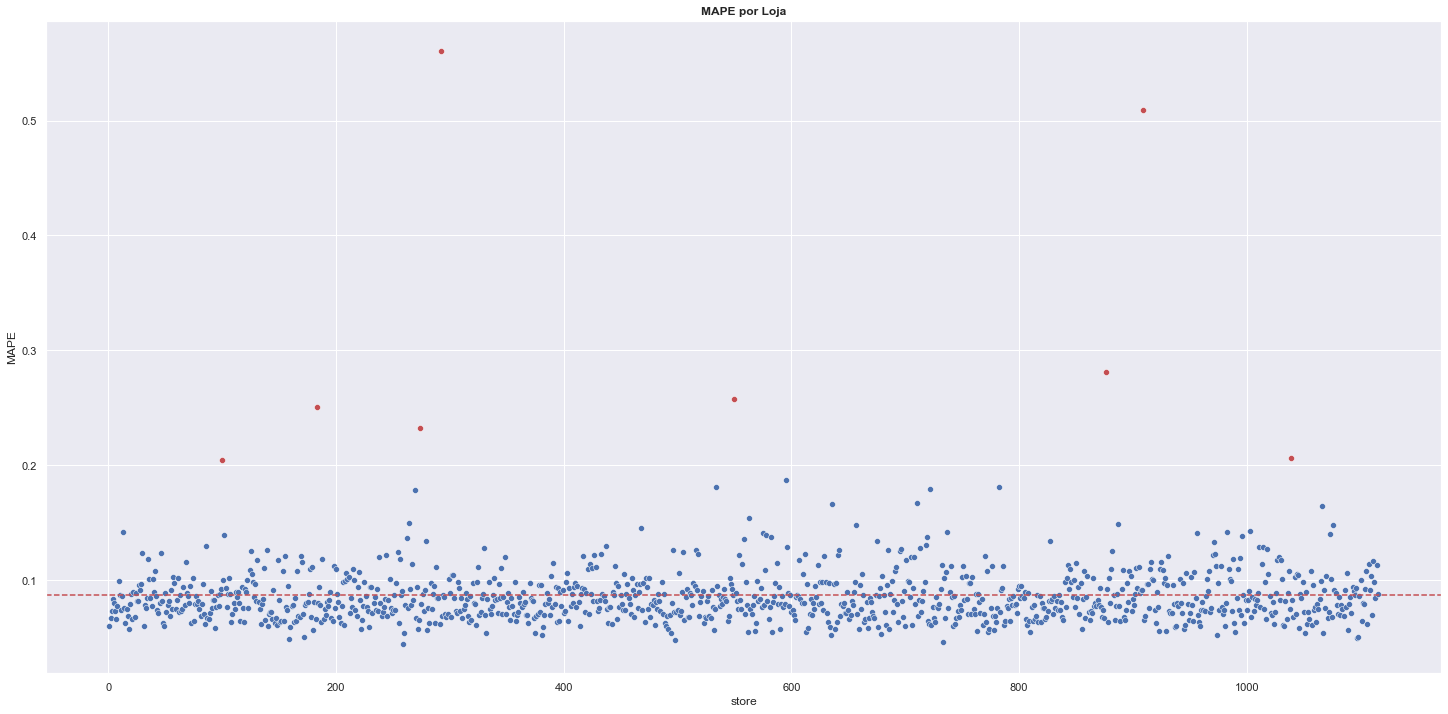

In [43]:
sns.scatterplot(x='store', y='MAPE', data=df9_2.query('MAPE < 0.2'))
sns.scatterplot(x='store',
                y='MAPE',
                data=df9_2.query('MAPE >= 0.2'),
                color='r')

plt.axhline(y=df9_2['MAPE'].mean(), linestyle='--', color='r')

plt.title("MAPE por Loja")

In [44]:
# Lojas mais faceis de fazer previsão:

df9_2.sort_values('MAPE', ascending=True).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE,MPE
258,259,535135.87500,534549.854878,535721.895122,586.020122,0.044989,0.017415
732,733,631311.00000,630632.754792,631989.245208,678.245208,0.046595,-0.003599
497,498,257387.78125,257049.812711,257725.749789,337.968539,0.047931,0.002021
158,159,285388.43750,285010.541557,285766.333443,377.895943,0.049046,-0.003725
1096,1097,439813.50000,439259.978016,440367.021984,553.521984,0.050259,0.041683


## 9.2 - Total Performance

In [45]:
df9_2[['predictions', 'worst_scenario',
       'best_scenario']].sum().map("€{:,.2f}".format).to_frame().T

,predictions,worst_scenario,best_scenario
0,"€282,234,624.00","€281,558,899.97","€282,910,310.83"


## 9.3 - Machine Learning Performance

In [46]:
df9['error'] = df9['sales'].values - df9['predictions'].values
df9['error_rate'] = df9['predictions'].values / df9['sales'].values

#### Comparando as vendas e as predições ao longo do tempo para **todas as lojas**

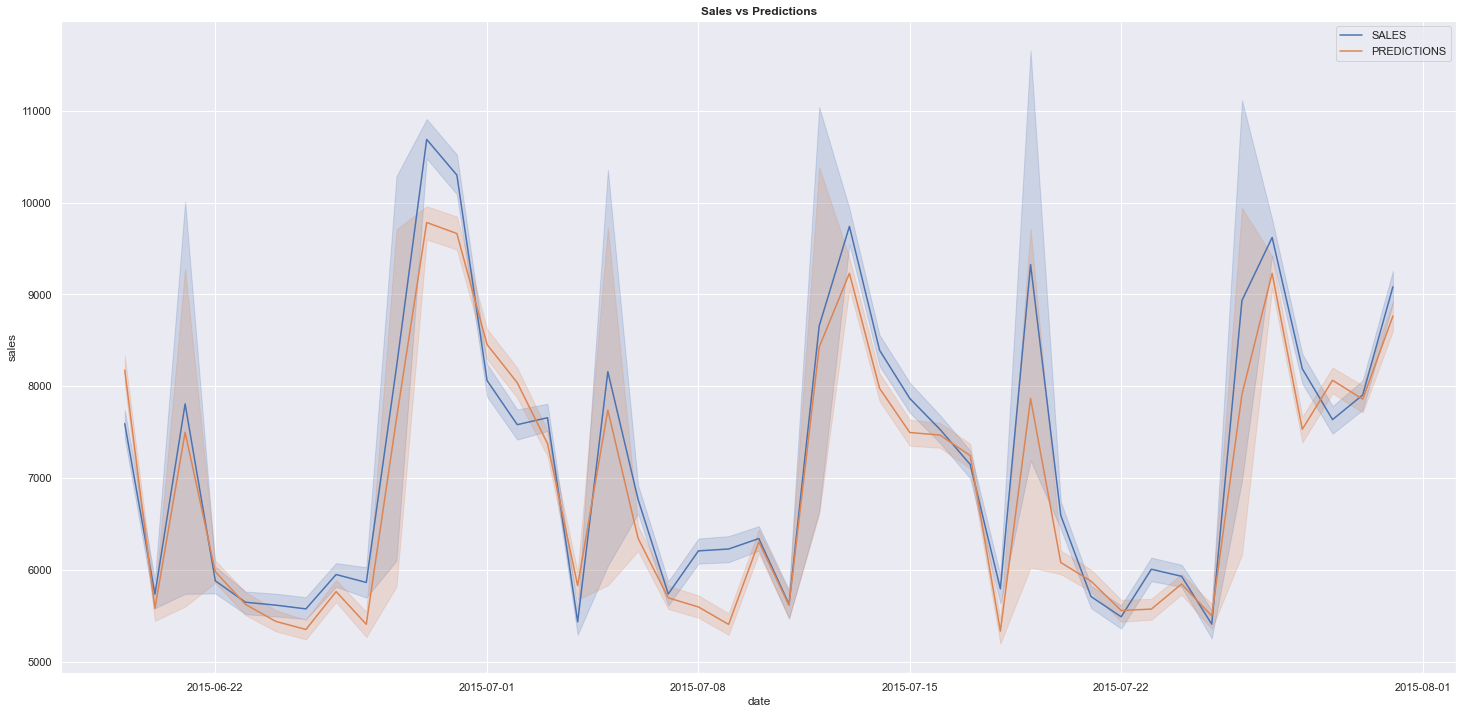

In [47]:
sns.lineplot(x='date', y='sales', data=df9, label="SALES")
sns.lineplot(x='date', y='predictions', data=df9, label="PREDICTIONS")
plt.title('Sales vs Predictions')
plt.show()

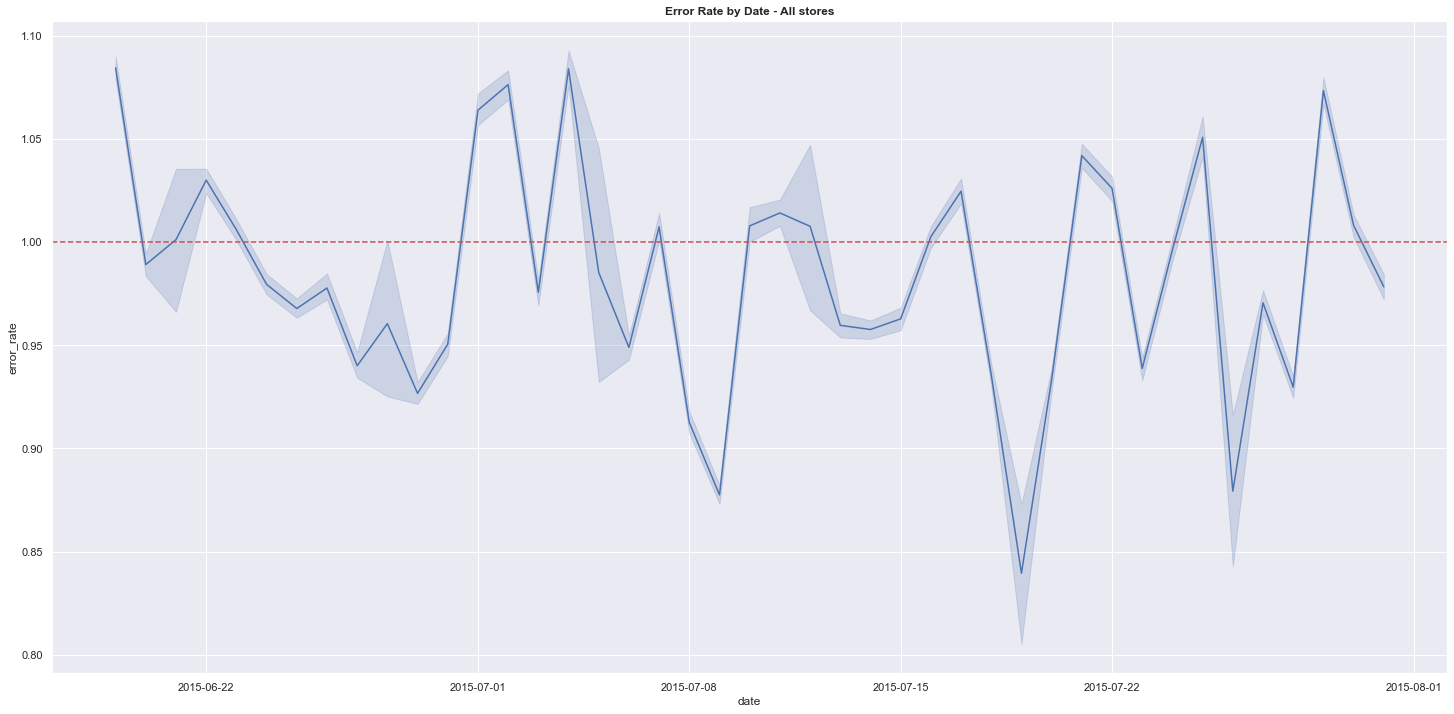

In [48]:
sns.lineplot(x='date', y='error_rate', data=df9)
plt.title('Error Rate by Date - All stores')
plt.axhline(1, linestyle='--', color='r')
plt.show()

#### Comparando as vendas e as predições ao longo do tempo da loja com previsão MAIS assertiva

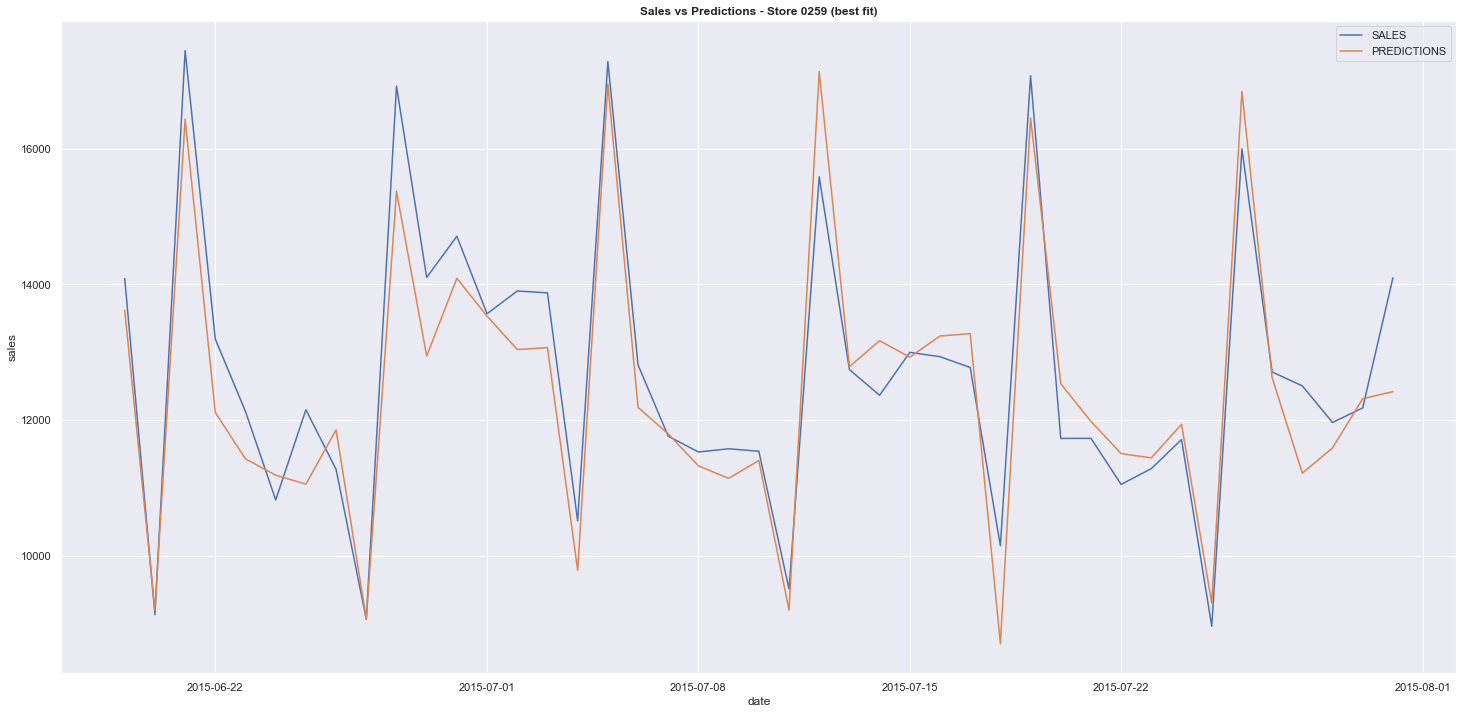

In [49]:
sns.lineplot(x='date',
             y='sales',
             data=df9.query('store == 259'),
             label="SALES",
             markers='.')
sns.lineplot(x='date',
             y='predictions',
             data=df9.query('store == 259'),
             label="PREDICTIONS")
plt.title('Sales vs Predictions - Store 0259 (best fit)')
plt.show()

#### Comparando as vendas e as predições ao longo do tempo da loja com previsão MENOS assertiva

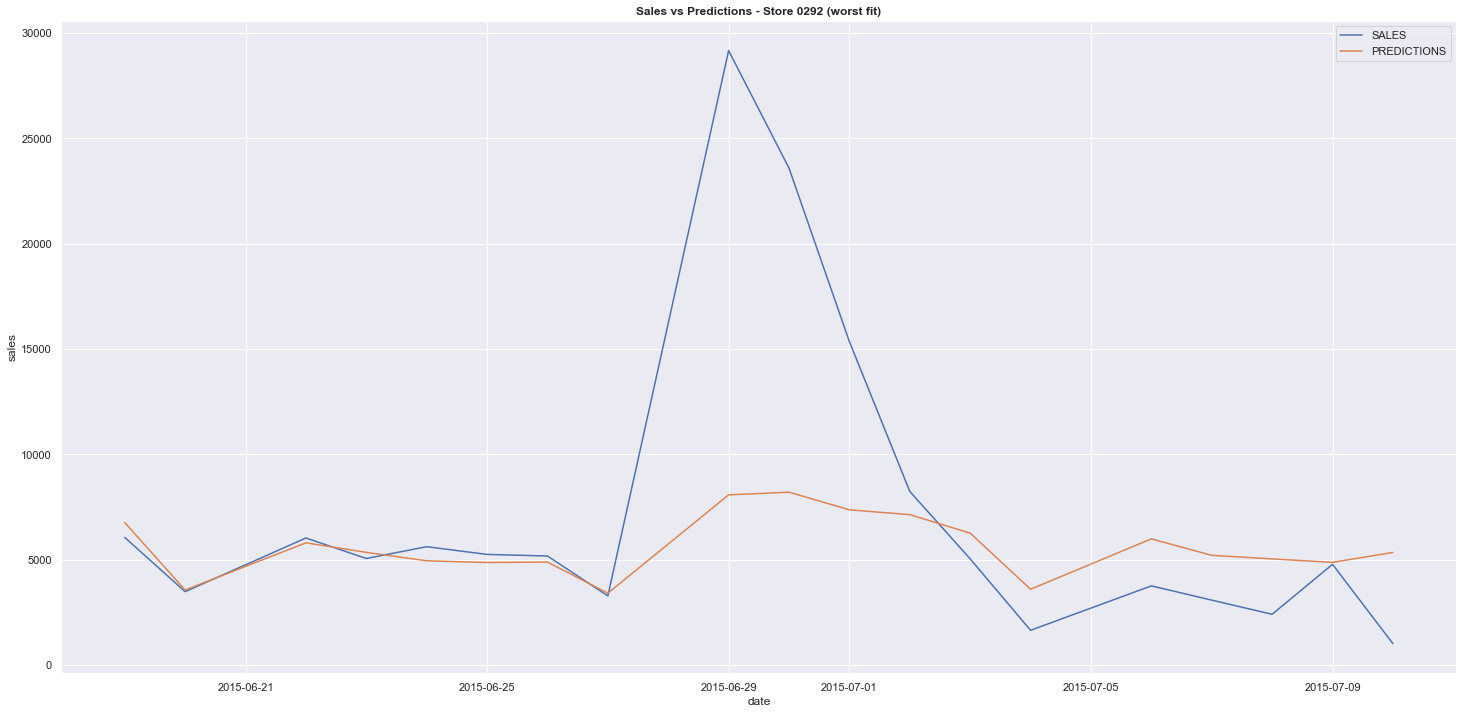

In [50]:
sns.lineplot(x='date',
             y='sales',
             data=df9.query('store == 292'),
             label="SALES")
sns.lineplot(x='date',
             y='predictions',
             data=df9.query('store == 292'),
             label="PREDICTIONS")
plt.title('Sales vs Predictions - Store 0292 (worst fit)')
plt.show()

#### Distribuição do erro (análise de resíduos)

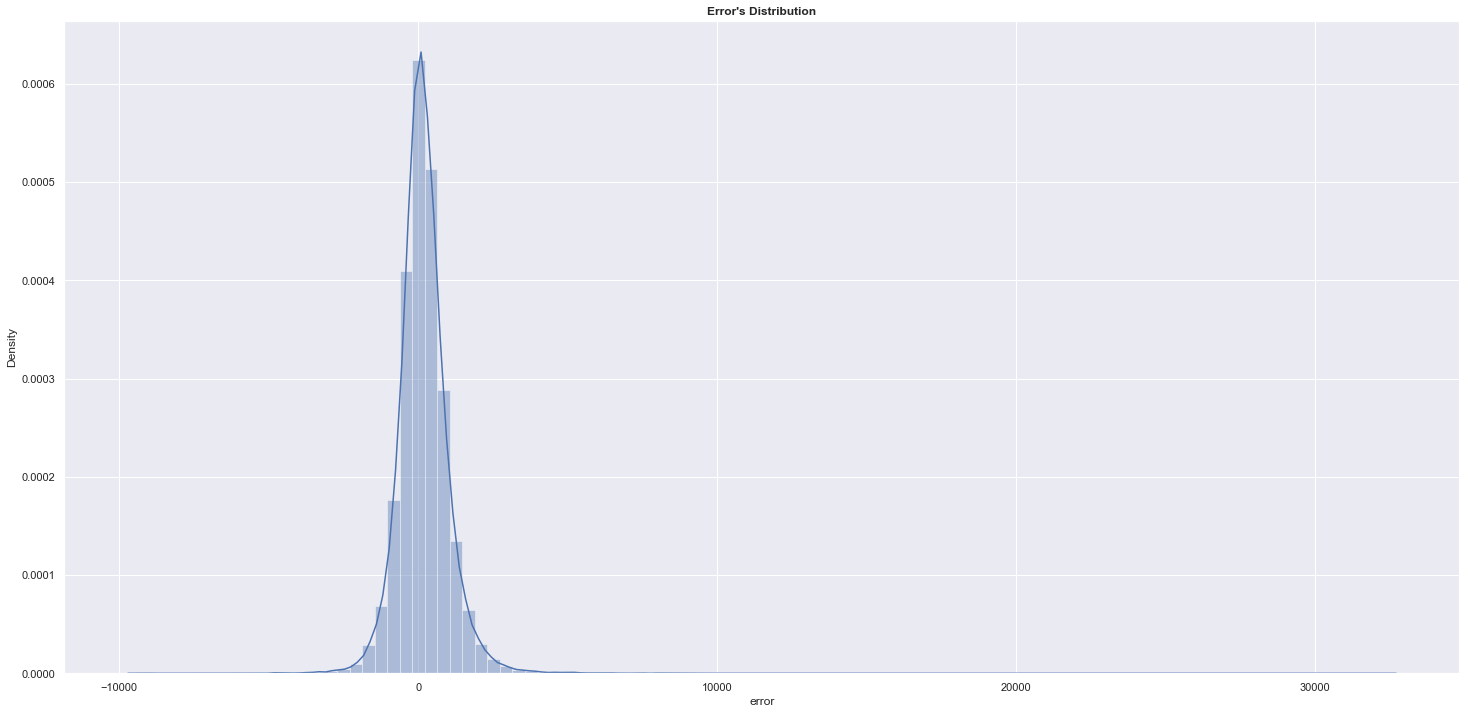

In [51]:
# Quanto mais próximo de uma normal, melhor

sns.distplot(df9['error'], bins=100)
plt.title('Error\'s Distribution')
plt.show()

#### Predictions vs Error (análise de resíduos)

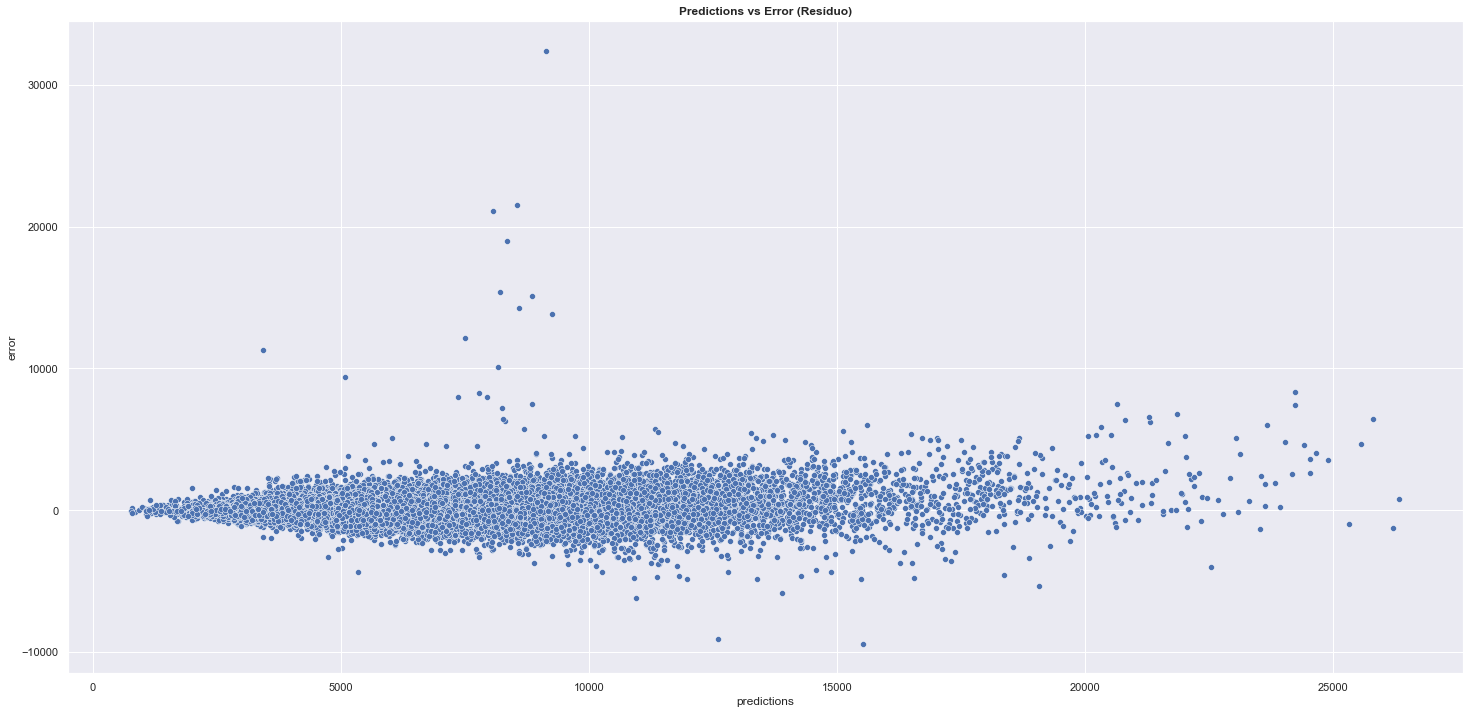

In [52]:
# Quanto mais limitado por um tubo (imaginário), melhor

sns.scatterplot(df9['predictions'], df9['error'])
plt.title('Predictions vs Error (Resíduo)')
plt.show()

# 10.0 - DEPLOY MODEL TO PRODUCTION

__Leitura importante__: [Machine Learning in Production: Lessons Learned from Deploying Our First ML Model](https://thenewstack.io/machine-learning-in-production-lessons-learned-from-deploying-our-first-ml-model/)


> **Para o próximo ciclo:** Colocar todas as transformações, limpezas e encodings em Pipelines do sklean.

> O código do modelo em produção pode ser acessado [aqui](https://github.com/PatrickRudgeri/rossmann-forecasting-webapi)

## 10.1 - API Consumer

> Aqui fiz um exemplo de como realizar as requisições na API

In [59]:
import json
import requests

In [60]:
# loading test dataset
df_test_raw = pd.read_csv("data/test.csv")
df_store_raw = pd.read_csv("data/store.csv")

In [61]:
# merge test + store
df_test = pd.merge(df_test_raw, df_store_raw, on="Store", how="left")

In [62]:
# choose store for prediction
def df_test_stores(stores):
    df1 = df_test.query("Store in @stores")
    return df1[(df1["Open"] != 0) & (~df1["Open"].isnull())]

def df_test_all():
    return df_test[(df_test["Open"] != 0) & (~df_test["Open"].isnull())]

In [63]:
 # orientação == records (cada registro == um dict)
data = df_test_stores([1, 21]).to_json(orient="records")
# data = json.dumps(df_test_all().to_dict(orient="records"))

In [ ]:
# API call
endpoint = "https://rossmann-sales-predictions.herokuapp.com/"
# endpoint = "http://localhost:5000/"

url = endpoint + "rossmann/predict"
header = {"Content-type": "application/json"}


r = requests.post(url, data=data, headers=header)
print("Status code {}".format(r.status_code))

In [ ]:
# # predicões
pred = pd.DataFrame(r.json())
pred[["Store","Date", "prediction"]].head(5)

In [ ]:
# Vendas Totais das proximas 6 semanas
sum_by_store = pred[["Store", "prediction"]].groupby("Store").sum().reset_index()

for _, row in sum_by_store.iterrows():
# for _, row in sum_by_store.sample(5).iterrows():
    print("A loja {} venderá €{:,.2f} nas próximas 6 semanas.".format(row["Store"].astype(int), row["prediction"]))

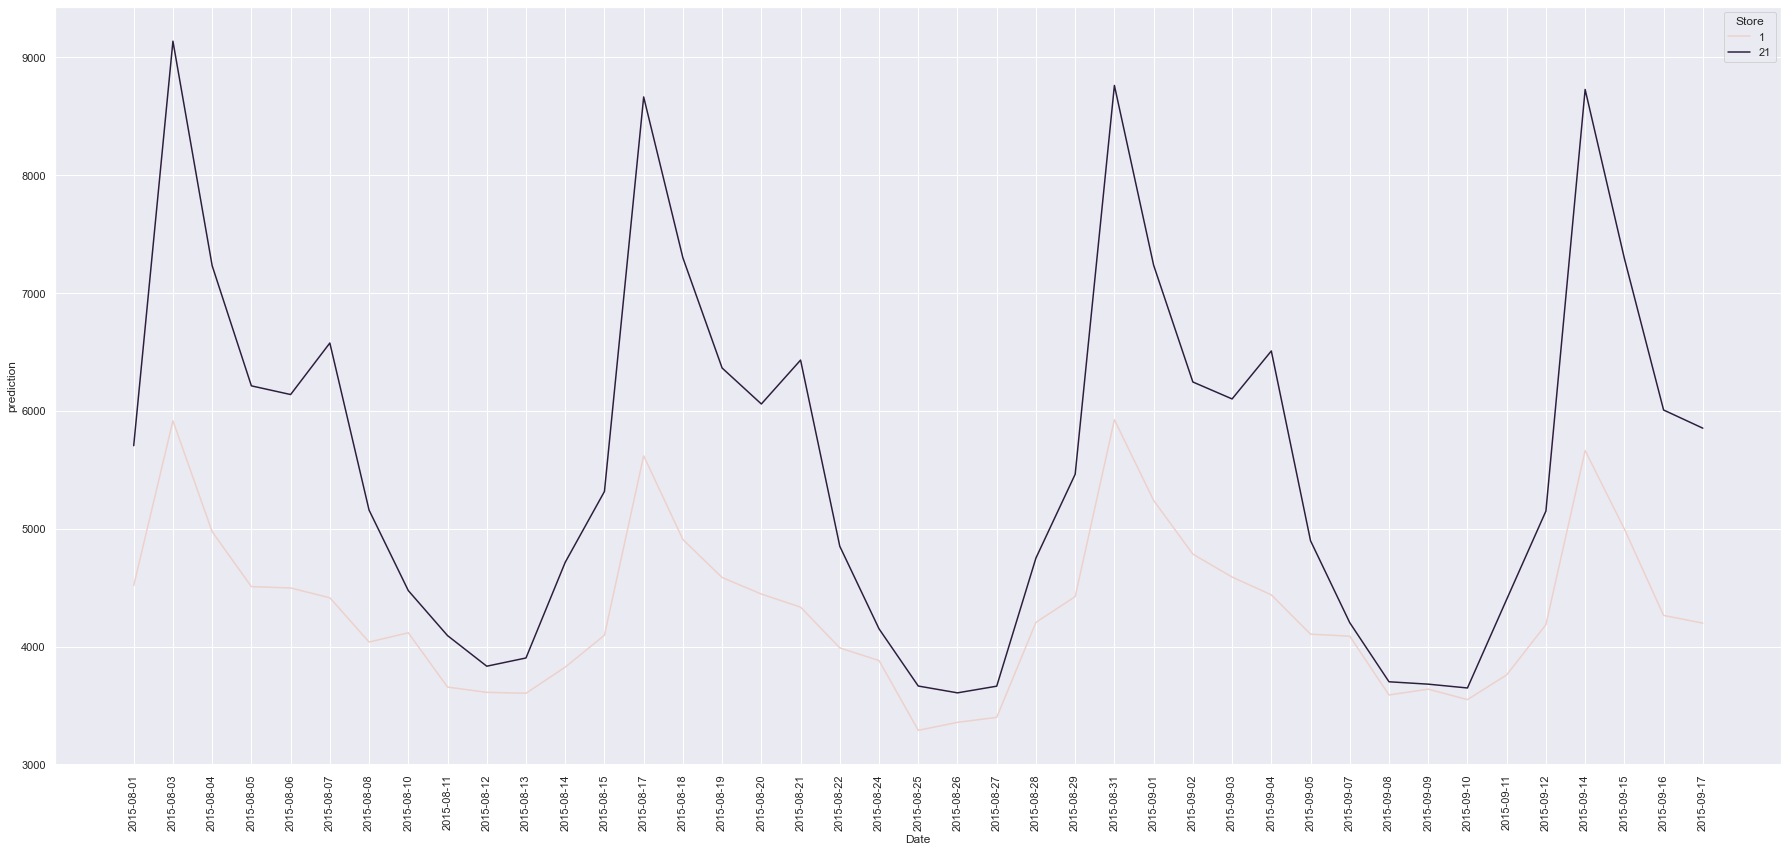

In [72]:
sns.lineplot(data=pred.set_index("Date").sort_index(), x="Date", y="prediction", hue="Store")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()